In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
from scipy.io import loadmat
from datetime import datetime, timedelta
import pycwt
import seaborn as sns
sys.path.append('/home/manu/TFG_repo/scripts')

In [3]:
from analysis_routines import *
from config import data_dir, reports_dir
from plotting_routines_xr import *
from processing_routines import datenum_to_epoch
from wavelet_analysis import wavelet_power_spectrum
from harmonic_analysis import *
from scipy.stats import chi2
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf
plt.style.use('/home/manu/TFG_repo/notebooks/mplstyles/report.mplstyle')

In [4]:
# load data and fit
fit_chain = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
chain = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')
station7 = load_time_series_xr('station7_complete.nc')
G05 = pd.read_csv(data_dir / 'SHDR_fit/aux/G05.csv', index_col='date', parse_dates=True)
delta05 = pd.read_csv(data_dir / 'SHDR_fit/aux/delta05_ci.csv', index_col='date', parse_dates=True)
D1_ = fit_chain.D1

In [5]:
# dates defining_periods
date_0 = datetime(2018, 11, 16, 11) # period_1
date_1 = datetime(2018, 11, 24)
period_1 = [date_0, date_1]

date_2 = datetime(2018, 11, 30) # period_2
date_3 = datetime(2018, 12, 9)
period_2 = [date_2, date_3]

date_4 = datetime(2019, 1, 5) # period_3
date_5 = datetime(2019, 1, 14)
period_3 = [date_4, date_5]

# internal solitons
date_s0 = datetime(2018, 11, 22, 20)
date_s1 = datetime(2018, 11, 23, 5)
date_s0f = datetime(2018, 11, 22, 22)
date_s1f = datetime(2018, 11, 23, 0, 15)
period_s1f = [date_s0f, date_s1f]

date_s2 = datetime(2018, 11, 19, 19)
date_s3 = datetime(2018, 11, 20, 6)
date_s2f = datetime(2018, 11, 19, 20)
date_s3f = datetime(2018, 11, 20, 0, 15)
period_s2f = [date_s2f, date_s3f]

date_s4 = datetime(2018, 11, 18, 4)
date_s5 = datetime(2018, 11, 18, 13)
date_s4f = datetime(2018, 11, 18, 5, 50)
date_s5f = datetime(2018, 11, 18, 9, 30)
period_s3f = [date_s4f, date_s5f]

date_s6 = datetime(2018, 11, 21, 8)
date_s8 = datetime(2018, 11, 21, 16)
date_s6f = datetime(2018, 11, 21, 10)
date_s8f = datetime(2018, 11, 21, 12, 15)
period_s4f = [date_s6f, date_s8f]

date_s9 = datetime(2018, 11, 18, 18)
date_s10 = datetime(2018, 11, 19, 1)
date_s9f = datetime(2018, 11, 18, 20)
date_s10f = datetime(2018, 11, 18, 22)
period_s5f = [date_s9f, date_s10f]

date_11 = datetime(2018, 11, 21, 21)
date_12 = datetime(2018, 11, 22, 6)



In [6]:
bot_pres = pd.read_csv(data_dir / 'time_series/pressure_sensor/20181116_DanoisMoat.csv', 
                       index_col='date', parse_dates=True)

In [7]:
# global variables
figures_dir = reports_dir / 'figures'
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

D1_ = fit_chain.D1
G005_ = G05.x

D1_filt64 = lowpass_filter(fit_chain.D1, chain.date, 1/5, 1/64)
G005_filt64 = lowpass_filter(G05.x, chain.date, 1/5, 1/64)


D1_filt512 = lowpass_filter(fit_chain.D1, chain.date, 1/5, 1/512)
G005_filt512 = lowpass_filter(G05.x, chain.date, 1/5, 1/512)

D1_filt1024 = lowpass_filter(fit_chain.D1, chain.date, 1/5, 1/1024)
G005_filt1024 = lowpass_filter(G05.x, chain.date, 1/5, 1/1024)


D1_filt2048 = lowpass_filter(fit_chain.D1, chain.date, 1/5, 1/2048)
G005_filt2048 = lowpass_filter(G05.x, chain.date, 1/5, 1/2048)


low = period_to_freq(13.5, 'h')
high = period_to_freq(11.5, 'h')

low = period_to_freq(12.47*1.1, 'h')
high = period_to_freq(12.47*0.9, 'h')
D1_bandpass_M2 = bandpass_filter(fit_chain.D1, chain.date, 1/5, low, high)
G005_bandpass_M2 = bandpass_filter(G05.x, chain.date, 1/5, low, high)

D1_dn = detrend_normalize(D1_bandpass_M2)
G005_dn = detrend_normalize(G005_bandpass_M2)

hi = period_to_freq(6, 'h')
G005_filt6h = lowpass_filter(G05.x, chain.date, 1/5, hi)
D1_filt6h = lowpass_filter(fit_chain.D1, chain.date, 1/5, hi)



In [8]:
def get_figsize(wf=0.5, hf=None, rotate=False):
    """Parameters:
      - wf (float):  width fraction in columnwidth units
      - hf (float):  height fraction in columnwidth units.
                   Set by default to golden ratio.
      - columnwidth (float): width of the column in latex. Get this from LaTeX 
                               using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    
    if hf is None:
        hf = 1/1.333333
    
    if not rotate:
        columnwidth = 455.24411
    else:
        columnwidth = 693.4982
    
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

# Capitulo 2: Teoría

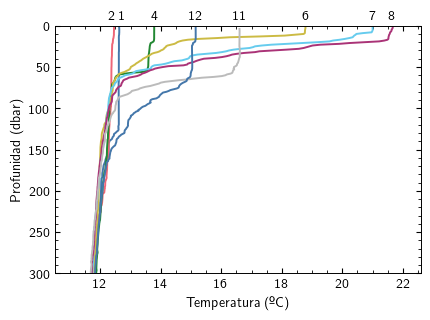

In [9]:
# profiles_2014
figsize = get_figsize(0.7)
fig, ax = plt.subplots(figsize=figsize)
year = station7.temp.sel(date='2014')
months_int = [0, 1, 3, 5, 6, 7, 10, 11]
for i in months_int:
    #k = i*2 + 1
    ax.plot(year[i], station7.pres)
    if i==0:
        ax.text(year[i][np.isfinite(year[i])][3] +0.1, -8, i + 1, ha='center')
    elif i==1:
        ax.text(year[i][np.isfinite(year[i])][3] -0.1, -8, i + 1, ha='center')     
    else:
        ax.text(year[i][np.isfinite(year[i])][3], -8, i + 1, ha='center')
ax.set_ylim(300, 0)
ax.set_xlim(10.5, None)
ax.set_xlabel('Temperatura (ºC)')
ax.set_ylabel('Profunidad (dbar)')
fig.tight_layout()
fig.savefig(reports_dir / 'figures/profiles_2014.pdf', dpi=300)
plt.show()

# Capitulo 3: Material y métodos

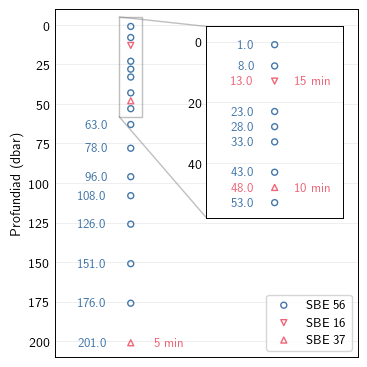

In [197]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
SBE56_depths = chain.meassured_depth[1].sel(depth=[  1.,   8.,  23.,  28.,  33.,  43.,  53.,  63.,  78.,  96.,
       108., 126., 151., 176.]).data
fig, ax = plt.subplots(figsize=get_figsize(0.6, 1))
ax.yaxis.grid(True, color='#EEEEEE')
ax.set_axisbelow(True)

ax.scatter(np.zeros(len(SBE56_depths)), SBE56_depths, label='SBE 56', marker='o', fc='None', ec=colors[0])
ax.scatter(0, 13, label='SBE 16', marker='v', fc='None', ec=colors[1])
ax.scatter([0, 0], [48, 201], c=colors[1], label='SBE 37', marker='^', fc='None', ec=colors[1])
for depth in SBE56_depths:
    if depth > 53:
        ax.text(-0.02, depth, str(depth), va='center', fontsize=9, c=colors[0], ha='right')
ax.text(0.02, 201, '5 min', va='center', fontsize=9, c=colors[1] )
ax.text(-0.02, 201, '201.0', va='center', fontsize=9, c=colors[0], ha='right')

ax.set_ylim(210, -10)
ax.tick_params(which='both', bottom=False, left=False, right=False, top=False)
ax.set_xticklabels([])
ax.set_xlim(-0.065, 0.195)


ax2 = ax.inset_axes([0.5, 0.4, 0.45, 0.55])
SBE56_upper = SBE56_depths[:7]

ax2.scatter(np.zeros(len(SBE56_upper)), SBE56_upper, marker='o', fc='None', ec=colors[0])
ax2.scatter(0, 13, label='SBE 16', marker ='v', fc='None', ec=colors[1])
ax2.scatter(0, 48, marker ='^', fc='None', ec=colors[1])

for depth in SBE56_upper:
        ax2.text(-0.003, depth, str(depth), va='center', fontsize=9, c=colors[0], ha='right')
ax2.text(-0.003, 13, str(13.0), va='center', fontsize=9, c=colors[1], ha='right')
ax2.text(-0.003, 48, str(48.0), va='center', fontsize=9, c=colors[1], ha='right')
ax2.text(0.003, 13, '15 min', va='center', fontsize=9, c=colors[1] )
ax2.text(0.003, 48, '10 min', va='center', fontsize=9, c=colors[1] )


ax2.tick_params(which='both', bottom=False, left=False, right=False, top=False)
ax2.set_xticklabels([])
ax2.set_xlim(-0.01, 0.01)
ax2.set_ylim(-5, 58)

ax.indicate_inset_zoom(ax2)
ax2.set_ylim(58, -5)
ax2.yaxis.grid(True, color='#EEEEEE')
ax2.set_axisbelow(True)


ax.legend(fontsize=9)
ax.set_ylabel('Profundiad (dbar)')
fig.tight_layout()
fig.savefig(figures_dir / 'chain_depths.pdf')
plt.show()

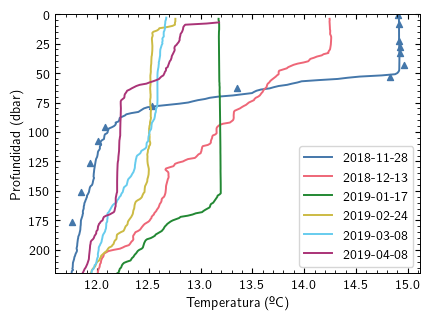

In [8]:
station7_period = station7.sel(date=slice(datetime(2018, 11, 10), datetime(2019, 4, 10)), pres=slice(0, 220))
fig, ax = plt.subplots(figsize=get_figsize(0.7))
for (temp, date) in zip(station7_period.temp.data, station7_period.date.data):
    label_str = np.datetime_as_string(date, unit='D')

    ax.plot(temp, station7_period.pres, label=label_str)

ax.scatter(chain.temp.loc[datetime(2018, 11, 28, 7, 54, 20)], chain.depth, c=colors[0], marker='^')

ax.set_ylim(220, 0)
ax.set_xlabel('Temperatura (ºC)')
ax.set_ylabel('Profundidad (dbar)')
ax.legend()
fig.tight_layout()
fig.savefig(figures_dir / 'station7_period.pdf')
plt.show()

In [202]:
chain.meassured_depth[:1000000, -1].mean()

<xarray.DataArray 'meassured_depth' ()>
array(212.2557, dtype=float32)
Coordinates:
    depth    int32 201

In [71]:
SBE56_upper

array([0, 1, 2, 3, 4, 5, 6])

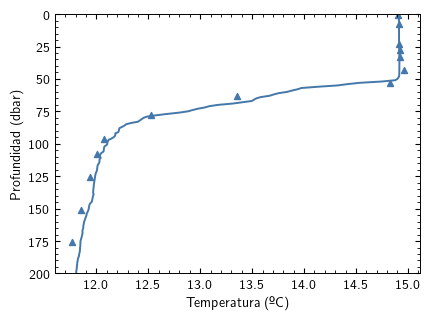

In [22]:
figsize = get_figsize(0.7)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(station7.temp.loc['2018-11'].sel(pres=slice(0, 200))[0].data, station7.pres.sel(pres=slice(0, 200)))
ax.scatter(chain.temp.loc[datetime(2018, 11, 28, 7, 54, 20)], chain.depth, c=colors[0], marker='^')
ax.set_ylabel('Profundidad (dbar)')
ax.set_xlabel('Temperatura (ºC)')
ax.set_ylim(200, 0)
fig.tight_layout()
plt.savefig(figures_dir / 'CTD_and_chain.pdf')
plt.show()

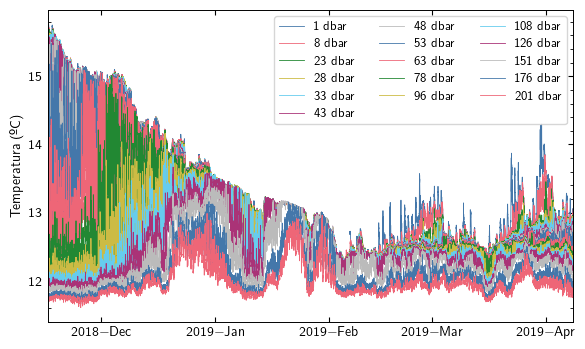

In [73]:
figsize=get_figsize(0.95, 0.6)
fig, ax= plt.subplots(figsize=(figsize))

labels = [str(i) + ' dbar' for i in chain.depth.data]
ax.plot(chain.date[::120].data, chain.temp[::120].data, lw=0.6, label=labels)
ax.set_xlim(chain.date[0].data, chain.date[-1].data)
ax.set_ylabel('Temperatura (ºC)')
ax.legend(loc=1, ncol=3, fontsize=9)
ax.tick_params(which='minor', axis='x', top=None, bottom=None)


ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b"))
fig.tight_layout()
fig.savefig(figures_dir / 'thermistors_complete.pdf')
plt.show()

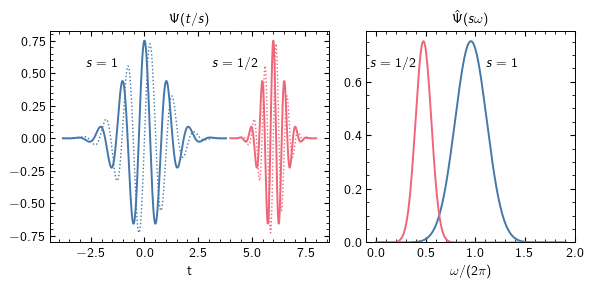

In [109]:
gs = plt.GridSpec(1, 2, width_ratios=(2, 1.5))
fig= plt.figure(figsize=get_figsize(0.95, 0.5))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
mother = pycwt.Morlet(6)
zz_1 = np.linspace(-3.8, 3.8, 300)
zz_3 = np.linspace(-2, 2, 300)
zz_3_1 = zz_3 + 6
ax1.plot(zz_1, np.real(mother.psi(zz_1)))
ax1.plot(zz_1, np.imag(mother.psi(zz_1)), ls=':', color=colors[0], lw=1)
ax1.text(0.13, 0.83, '$s=1$', transform= ax1.transAxes)

ax1.plot(zz_3_1, np.real(mother.psi(zz_3/0.5)), color=colors[1])
ax1.plot(zz_3_1, np.imag(mother.psi(zz_3/0.5)), color=colors[1], ls=':', lw=1)
ax1.text(0.58, 0.83, '$s=1/2$', transform= ax1.transAxes)

ax1.set_xlabel('t')
ax1.set_title('$\Psi (t/s)$')

zz_2 = np.linspace(0, 12, 300)
ax2.plot(zz_2/np.pi/2, mother.psi_ft(zz_2))
ax2.plot(zz_2/np.pi/2, mother.psi_ft(zz_2*2))
ax2.text(0.017, 0.83, '$s=1/2$', transform= ax2.transAxes)
ax2.text(0.57, 0.83, '$s=1$', transform= ax2.transAxes)

ax2.set_ylim(0, None)
ax2.set_xlabel(r'$\omega /(2\pi)$')
ax2.set_title(r'$\hat{\Psi}(s \omega)$')

fig.tight_layout()
fig.savefig(figures_dir / 'morlet.pdf')

plt.show()

# Capitulo 4: algoritmo SHDR

In [1]:
loc = datetime(2018, 11, 21, 1, 12)
data_loc = chain.sel(date=loc)
fit_loc = fit_chain.loc[loc]
fig, ax = plt.subplots(figsize=get_figsize(0.7, 1))
zz = np.linspace(1, 175, 300)
ax.scatter(data_loc.temp, data_loc.depth, fc='None', ec=colors[1], s=28, linewidths=1.1)
ax.plot(fit_function(zz, fit_chain, loc), zz, c=colors[0])
ax.plot(fit_loc.a3 + fit_loc.b3*(zz-fit_loc.D1), zz, lw=1.2, ls='--')
ax.axhline(fit_loc.D1, ls='--', lw=1.2)
trans = ax.transAxes
ax.text(15.6, fit_loc.D1, '$D_1$', va='center')
ax.text(11.73, 100, '$b_3(z - D_1)$', rotation=84)
ax.text(11.9, 38, '$a_3$')
ax.set_ylim(181, 0)
ax.vlines(fit_loc.a3, fit_loc.D1, 0, ls=':', color='grey')
ax.text(fit_loc.a1, - 5, '$a_1$', ha='center')

ax.annotate('$\sim exp[(-b_2(z - D_1) -c_2(z-D_1)^2]$', xy=[13.4, 63], xytext=[12.7, 100],
            arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))

ax.scatter(fit_loc.a3, fit_loc.D1, marker='x', s=24, c='k')

ax.annotate(text='', xy=(fit_loc.a3, 20), xytext=(fit_loc.a1,20),  
            arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0))
ax.text(fit_loc.a3 + (fit_loc.a1 - fit_loc.a3)/2, 18, '$a_2$')
ax.set_xlim(11.5, None)
date_loc_str = np.datetime_as_string(chain.date.loc[loc].data, 's').replace('T', ' ')
ax.text(0.6, 0.1, date_loc_str, transform=ax.transAxes, fontsize=9)
ax.set_xlabel('Temperatura ($^{\mathrm{o}}$C)')
ax.set_ylabel('Profundidad (dbar)')
fig.tight_layout()
fig.savefig(figures_dir / 'parametres.pdf')
plt.show()

NameError: name 'datetime' is not defined

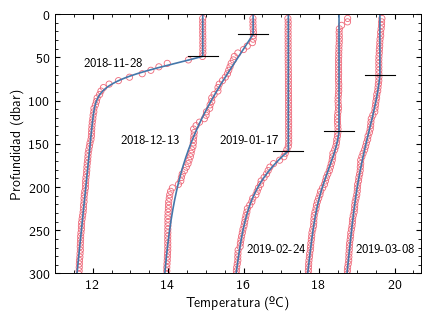

In [116]:
station7_fit = load_SHDR_fit('station7_complete_fit.csv')
fig, ax = plt.subplots(figsize=get_figsize(0.7))
loc = 238
date_loc_str = np.datetime_as_string(station7.date[loc].data, 'D').replace('T', ' ')
zz = np.linspace(1, 300, 300)
ax.scatter(station7.temp[loc][::4], station7.pres[::4], fc='None', ec=colors[1], s=20, linewidths=0.6)
ax.plot(fit_function(zz, station7_fit, loc), zz, c=colors[0] , lw=1.2)
ax.plot(fit_function(station7_fit.iloc[loc].D1, station7_fit, loc) + np.array([-0.4, 0.4]),
        [station7_fit.iloc[loc].D1, station7_fit.iloc[loc].D1] ,c='k', lw=0.8)
ax.text(0.08, 0.8, date_loc_str, transform=ax.transAxes, fontsize=9)

loc = 239
off = 2
date_loc_str = np.datetime_as_string(station7.date[loc].data, 'D').replace('T', ' ')
zz = np.linspace(1, 300, 300)
ax.scatter(station7.temp[loc][::4] + off, station7.pres[::4], fc='None', ec=colors[1], s=20, linewidths=0.6)
ax.plot(fit_function(zz, station7_fit, loc) + off, zz, c=colors[0] , lw=1.2)
ax.plot(fit_function(station7_fit.iloc[loc].D1, station7_fit, loc) + off + np.array([-0.4, 0.4]),
        [station7_fit.iloc[loc].D1, station7_fit.iloc[loc].D1] ,c='k', lw=0.8)
ax.text(0.18, 0.5, date_loc_str, transform=ax.transAxes, fontsize=9)


loc = 240
off = 4
date_loc_str = np.datetime_as_string(station7.date[loc].data, 'D')
zz = np.linspace(1, 300, 300)
ax.scatter(station7.temp[loc][::4] + off, station7.pres[::4], fc='None', ec=colors[1], s=20, linewidths=0.6)
ax.plot(fit_function(zz, station7_fit, loc) + off, zz, c=colors[0] , lw=1.2)

ax.plot(fit_function(station7_fit.iloc[loc].D1, station7_fit, loc) + off + np.array([-0.4, 0.4]),
        [station7_fit.iloc[loc].D1, station7_fit.iloc[loc].D1] ,c='k', lw=0.8)
ax.text(0.45, 0.5, date_loc_str, transform=ax.transAxes, fontsize=9)

loc = 241
off = 6
date_loc_str = np.datetime_as_string(station7.date[loc].data, 'D').replace('T', ' ')
zz = np.linspace(1, 300, 300)
ax.scatter(station7.temp[loc][::4] + off, station7.pres[::4], fc='None', ec=colors[1], s=20, linewidths=0.6)
ax.plot(fit_function(zz, station7_fit, loc) + off, zz, c=colors[0] , lw=1.2)
ax.plot(fit_function(station7_fit.iloc[loc].D1, station7_fit, loc) + off + np.array([-0.4, 0.4]),
        [station7_fit.iloc[loc].D1, station7_fit.iloc[loc].D1] ,c='k', lw=0.8)
ax.text(0.525, 0.08, date_loc_str, transform=ax.transAxes, fontsize=9)

loc = 242
off = 7
date_loc_str = np.datetime_as_string(station7.date[loc].data, 'D').replace('T', ' ')
zz = np.linspace(1, 300, 300)
ax.scatter(station7.temp[loc][::4] + off, station7.pres[::4], fc='None', ec=colors[1], s=20, linewidths=0.6)
ax.plot(fit_function(zz, station7_fit, loc) + off, zz, c=colors[0] , lw=1.2)
ax.plot(fit_function(station7_fit.iloc[loc].D1, station7_fit, loc) + off + np.array([-0.4, 0.4]),
        [station7_fit.iloc[loc].D1, station7_fit.iloc[loc].D1] ,c='k', lw=0.8)
ax.text(0.823, 0.08, date_loc_str, transform=ax.transAxes, fontsize=9)

ax.set_ylim(300, 0)
ax.set_xlim(11, 20.7)

ax.set_xlabel('Temperatura (ºC)')
ax.set_ylabel('Profundidad (dbar)')
fig.tight_layout()
fig.savefig(figures_dir / 'station7_period_fit.pdf')
plt.show()

In [18]:
df_g = load_SHDR_fit('old_fits/AGL_1_SB56_Grenoble.csv')
df_ci = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
df_c = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fc.csv')
df_s = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_s.csv')
df_g.index = df_g.index - np.timedelta64(365, 'D') + np.timedelta64(1, 'h')

In [19]:
date_final = df_s.index[-1]
df_s = df_s.loc[slice(None,datetime(2019, 4, 8, 9, 0, 25))]
df_g = df_g.loc[slice(None, datetime(2019, 4, 8, 9, 0, 24))]

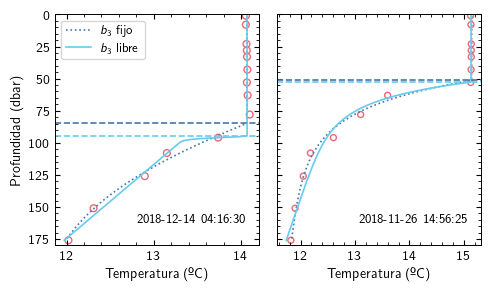

In [165]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=get_figsize(0.8, 0.6), sharey=True)

loc = 478998
ax1.scatter(chain.temp[loc], chain.depth, fc='None', ec=colors[1], s=24)
date_loc_str = np.datetime_as_string(chain.date[loc].data, 's').replace('T', ' ')
zz = np.linspace(1, 176, 300)
ax1.plot(fit_function(zz, fit_chain, loc), zz, c=colors[0], label='$b_3$ fijo', ls=':', lw=1.2)
ax1.plot(fit_function(zz, df_g, loc), zz, c=colors[4], label='$b_3$ libre', lw=1.2)
ax1.axhline(fit_chain.iloc[loc].D1, c=colors[0], ls='--', lw=1.2)# plot MLD
ax1.axhline(df_g.iloc[loc].D1, c=colors[4], ls='--', lw=1.2) # plot MLD
ax1.text(0.4, 0.1, date_loc_str, transform=ax1.transAxes, fontsize=9)

loc = 175637
date_loc_str = np.datetime_as_string(chain.date[loc].data, 's').replace('T', ' ')
ax2.scatter(chain.temp[loc], chain.depth, fc='None', ec=colors[1])
zz = np.linspace(1, 176, 300)
ax2.plot(fit_function(zz, fit_chain, loc), zz, c=colors[0], label='$b_3$ fijo', ls=':', lw=1.2)
ax2.plot(fit_function(zz, df_g, loc), zz, c=colors[4], label='$b_3$ libre', lw=1.2)
ax2.axhline(fit_chain.iloc[loc].D1, c=colors[0], ls='--', lw=1.2) # plot MLD
ax2.axhline(df_g.iloc[loc].D1, c=colors[4], ls='--', lw=1.2) # plot MLD
ax2.text(0.4, 0.1, date_loc_str, transform=ax2.transAxes, fontsize=9)

ax1.set_ylim(180, 0)
ax2.set_ylim(180, 0)
ax1.set_xlabel('Temperatura (ºC)')
ax2.set_xlabel('Temperatura (ºC)')
ax1.set_ylabel('Profundidad (dbar)')

ax1.legend(fontsize=9)

fig.tight_layout()
fig.savefig(figures_dir / 'b2_free_fixed.pdf')
plt.show()

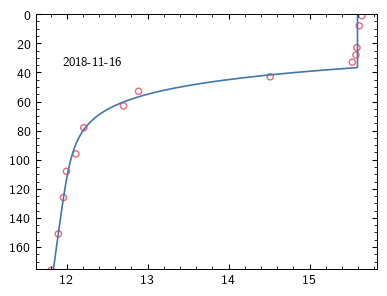

In [143]:
fig, ax = plt.subplots(figsize=get_figsize(0.7))
loc = 238
date_loc_str = np.datetime_as_string(chain.date[loc].data, 'D').replace('T', ' ')
zz = np.linspace(1, 176, 300)
ax.scatter(chain.temp[loc], chain.depth, fc='None', ec=colors[1], s=20)
ax.plot(fit_function(zz, fit_chain, loc), zz, c=colors[0] , lw=1.2)
#ax.plot(fit_function(fit_chain.iloc[loc].D1, fit_chain, loc) + np.array([-0.4, 0.4]),
#        [station7_fit.iloc[loc].D1, station7_fit.iloc[loc].D1] ,c='k', lw=0.8)
ax.text(0.08, 0.8, date_loc_str, transform=ax.transAxes, fontsize=9)
ax.set_ylim(175, 0)
plt.show()

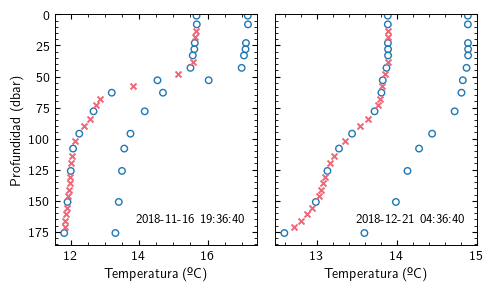

In [257]:
z = chain.meassured_depth[1][np.isfinite(chain.meassured_depth[1])].data
y = chain.temp[6200, :][np.isfinite(chain.meassured_depth[10])].data
z_intlin = [13, 18, 38, 48, 58, 68, 73, 84, 90, 102, 114, 120, 131, 136, 141, 146, 156, 161, 166, 171]
_, y_intlin = interpolate(z, y, z_intlin)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=get_figsize(0.8, 0.6), sharey=True)
date_loc_str = np.datetime_as_string(chain.date[6200].data, 's').replace('T', ' ')
ax1.scatter(y, z, marker='o', fc='None', ec='tab:blue', s=22)
ax1.scatter(y_intlin, z_intlin, marker='x')
ax1.scatter(y + 1.5, z, marker='o', fc='None', ec='tab:blue', s=22)
ax1.text(0.4, 0.1, date_loc_str, transform=ax1.transAxes, fontsize=9)

#ax.plot(y_int, z_int)
ax1.set_ylim(z[-1] + 10, 0)
ax1.set_xlabel('Temperatura (ºC)')
ax1.set_ylabel('Profundidad (dbar)')

y = chain.temp[600200, :][np.isfinite(chain.meassured_depth[10])].data
z_intlin = [13, 18, 38, 48, 58, 68, 73, 84, 90, 102, 114, 120, 131, 136, 141, 146, 156, 161, 166, 171]
_, y_intlin = interpolate(z, y, z_intlin)
date_loc_str = np.datetime_as_string(chain.date[600200].data, 's').replace('T', ' ')
ax2.scatter(y, z, marker='o', fc='None', ec='tab:blue', s=22)
ax2.scatter(y_intlin, z_intlin, marker='x')
ax2.scatter(y + 1, z, marker='o', fc='None', ec='tab:blue', s=22)
ax2.text(0.4, 0.1, date_loc_str, transform=ax2.transAxes, fontsize=9)

#ax.plot(y_int, z_int)
ax2.set_ylim(z[-1] + 10, 0)
ax2.set_xlabel('Temperatura (ºC)')
fig.tight_layout()
fig.savefig(figures_dir / 'interplolated_profiles.pdf')
plt.show()

In [1]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=get_figsize(0.8, 0.65), sharey=True)
loc = datetime(2018, 12, 21, 0, 13, 55)
#loc = datetime(2019, 1, 11, 11, 35, 50)
pres = chain.depth.data
ax1.scatter(chain.temp.loc[loc], pres, marker='o', fc='None', ec=colors[1], s=24)
zz = np.linspace(1, 175, 300)
date_loc_str = np.datetime_as_string(chain.date.loc[loc].data, 's').replace('T', ' ')
ax1.set_title(date_loc_str)
ax1.plot(fit_function(zz, df_s, loc), zz, lw=1.2, c=colors[2], label='s', ls='--')
ax1.plot(fit_function(zz, df_c, loc), zz, lw=1.2, c=colors[0], label='c', ls=':')
ax1.plot(fit_function(zz, fit_chain, loc), zz, lw=1.2, c=colors[1], label='c+i')

ax1.axhline(df_ci.loc[loc].D1, ls='-', c=colors[1])
ax1.axhline(df_c.loc[loc].D1, ls=':', c=colors[0])
ax1.axhline(df_s.loc[loc].D1, ls='--', c=colors[2])

ax1.set_ylim(180, 0)
ax1.set_ylabel('Profundidad (dbar)')
ax1.set_xlabel('Temperatura (ºC)')

ax1.legend()


loc += timedelta(seconds=+5)
date_loc_str = np.datetime_as_string(chain.date.loc[loc].data, 's').replace('T', ' ')
ax2.set_title(date_loc_str)
ax2.scatter(chain.temp.loc[loc], pres,  marker='o', fc='None', ec=colors[1], s=24)
ax2.plot(fit_function(zz, df_s, loc), zz, lw=1.2, c=colors[2], label='s', ls='--')
ax2.plot(fit_function(zz, df_c, loc), zz, lw=1.2, c=colors[0], label='c', ls=':')
ax2.plot(fit_function(zz, fit_chain, loc), zz, lw=1.2, c=colors[1], label='ci', ls='-')

ax2.axhline(df_c.loc[loc].D1, ls=':', c=colors[0])
ax2.axhline(df_ci.loc[loc].D1, ls='-', c=colors[1])
ax2.axhline(df_s.loc[loc].D1, ls='--', c=colors[2])
ax2.set_xlabel('Temperatura (ºC)')


ax2.set_ylim(180, 0)
fig.tight_layout()
fig.savefig(figures_dir / 'fit_modes_fit.pdf')
plt.show()

NameError: name 'plt' is not defined

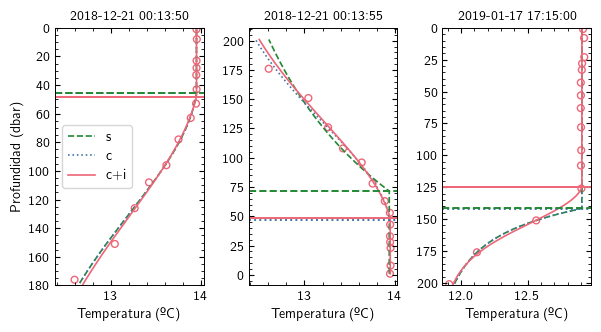

In [102]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=get_figsize(0.97, 0.56), sharey=False)
loc = datetime(2018, 12, 21, 0, 13, 50)
#loc = datetime(2019, 1, 11, 11, 35, 50)
pres = chain.depth.data
ax1.scatter(chain.temp.loc[loc], pres, marker='o', fc='None', ec=colors[1], s=24)
zz = np.linspace(1, 201, 300)
date_loc_str = np.datetime_as_string(chain.date.loc[loc].data, 's').replace('T', ' ')
ax1.set_title(date_loc_str)
ax1.plot(fit_function(zz, df_s, loc), zz, lw=1.2, c=colors[2], label='s', ls='--')
ax1.plot(fit_function(zz, df_c, loc), zz, lw=1.2, c=colors[0], label='c', ls=':')
ax1.plot(fit_function(zz, fit_chain, loc), zz, lw=1.2, c=colors[1], label='c+i')

ax1.axhline(df_ci.loc[loc].D1, ls='-', c=colors[1])
ax1.axhline(df_c.loc[loc].D1, ls=':', c=colors[0])
ax1.axhline(df_s.loc[loc].D1, ls='--', c=colors[2])

ax1.set_ylim(180, 0)
ax1.set_ylabel('Profundidad (dbar)')
ax1.set_xlabel('Temperatura (ºC)')

ax1.legend()


loc += timedelta(seconds=+5)
date_loc_str = np.datetime_as_string(chain.date.loc[loc].data, 's').replace('T', ' ')
ax2.set_title(date_loc_str)
ax2.scatter(chain.temp.loc[loc], pres,  marker='o', fc='None', ec=colors[1], s=24)
ax2.plot(fit_function(zz, df_s, loc), zz, lw=1.2, c=colors[2], label='s', ls='--')
ax2.plot(fit_function(zz, df_c, loc), zz, lw=1.2, c=colors[0], label='c', ls=':')
ax2.plot(fit_function(zz, fit_chain, loc), zz, lw=1.2, c=colors[1], label='ci', ls='-')

ax2.axhline(df_c.loc[loc].D1, ls=':', c=colors[0])
ax2.axhline(df_ci.loc[loc].D1, ls='-', c=colors[1])
ax2.axhline(df_s.loc[loc].D1, ls='--', c=colors[2])
ax2.set_xlabel('Temperatura (ºC)')

loc = datetime(2019, 1, 17, 17, 15, 0)
date_loc_str = np.datetime_as_string(chain.date.loc[loc].data, 's').replace('T', ' ')
ax3.set_title(date_loc_str)
ax3.scatter(chain.temp.loc[loc], pres,  marker='o', fc='None', ec=colors[1], s=24)
ax3.plot(fit_function(zz, df_s, loc), zz, lw=1.2, c=colors[2], label='s', ls='--')
ax3.plot(fit_function(zz, df_c, loc), zz, lw=1.2, c=colors[0], label='c', ls=':')
ax3.plot(fit_function(zz, fit_chain, loc), zz, lw=1.2, c=colors[1], label='ci', ls='-')

ax3.axhline(df_c.loc[loc].D1, ls=':', c=colors[0])
ax3.axhline(df_ci.loc[loc].D1, ls='-', c=colors[1])
ax3.axhline(df_s.loc[loc].D1, ls='--', c=colors[2])
ax3.set_xlabel('Temperatura (ºC)')


ax3.set_ylim(202, 0)
fig.tight_layout()
fig.savefig(figures_dir / 'fit_modes_fit.pdf')
plt.show()

In [21]:
locs_5_s, ratio_5_s = distance(df_s, 'D1', 1, 5)
locs_10_s, ratio_10_s = distance(df_s, 'D1', 1, 10)
locs_15_s, ratio_15_s = distance(df_s, 'D1', 1, 15)
locs_5_c, ratio_5_c = distance(df_c, 'D1', 1, 5)
locs_10_c, ratio_10_c = distance(df_c, 'D1', 1, 10)
locs_15_c, ratio_15_c = distance(df_c, 'D1', 1, 15)
locs_5_ci, ratio_5_ci = distance(fit_chain, 'D1', 1, 5)
locs_10_ci, ratio_10_ci = distance(fit_chain, 'D1', 1, 10)
locs_15_ci, ratio_15_ci = distance(fit_chain, 'D1', 1, 15)

ratios_5 = np.array([ratio_5_s, ratio_5_c, ratio_5_ci])*100
ratios_10 = np.array([ratio_10_s, ratio_10_c, ratio_10_ci])*100
ratios_15 = np.array([ratio_15_s, ratio_15_c, ratio_15_ci])*100
total_ratios = [ratios_5, ratios_10, ratios_15]

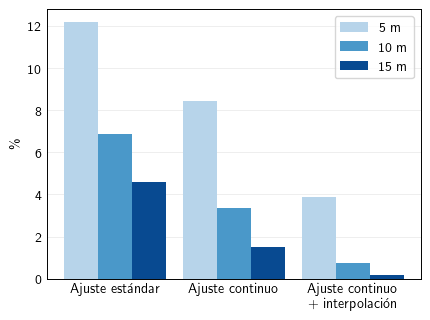

In [23]:
fig, ax = plt.subplots(figsize=get_figsize(0.7))
x = np.array([0, 1.4, 2.8])
bar_width = 0.4
colors = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
b1 = ax.bar(x, ratios_5, width=bar_width, label='5 m', color=colors[0])
b2 = ax.bar(x + bar_width, ratios_10, width=bar_width, label='10 m', color=colors[1])
b3 = ax.bar(x + bar_width*2, ratios_15, width=bar_width, label='15 m', color=colors[2])
ax.tick_params(which='both', bottom=False, left=False, right=False, top=False)
ax.set_axisbelow(True)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(['Ajuste estándar', 'Ajuste continuo', 'Ajuste continuo\n+ interpolación'])
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.legend()
ax.set_ylabel('\%')
fig.tight_layout()
fig.savefig(figures_dir / 'barplot_fit.pdf')
plt.show()

# Capitulo 5: Resultados

## Variabilidad estacional

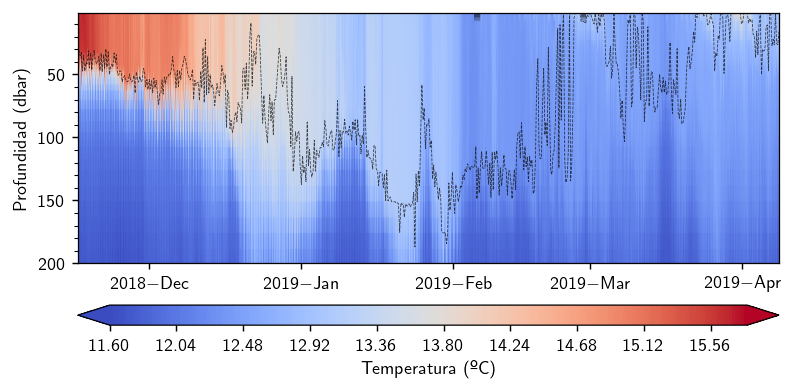

In [33]:
slice_ = slice(None, None, 120*12)
chain_period = chain.isel(date=slice_)
fig, ax = plt.subplots(figsize=get_figsize(0.99, 0.5))
cmap = plt.colormaps['coolwarm']


#locator = mdates.AutoDateLocator(minticks=4, maxticks=None)
#formatter = mdates.ConciseDateFormatter(locator)
#minor_locator = mdates.AutoDateLocator(minticks=6)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
#ax.xaxis.set_minor_locator(minor_locator)

levels = MaxNLocator(nbins=256).tick_values(chain.temp.min(), chain.temp.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
ax.set_ylim(200, 1)
x, y = np.meshgrid(chain_period.date, chain_period.depth)


divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='8%', pad=0.32)
im = ax.pcolormesh(x.T, y.T, chain_period.temp, cmap=cmap, norm=norm, shading='gouraud')
cbar = fig.colorbar(im, cax=cax, extend='both', orientation="horizontal")

xx = np.linspace(0, len(chain.date.data[::120*4]) - 1, 600, dtype='int')

ax.plot(chain.date.data[::120*4][xx], fit_chain.D1[::120*4][xx], c='black', lw=0.45, ls='--', alpha=0.7)

cbar.ax.tick_params(which='minor', axis='x', bottom=False)
cbar.ax.tick_params(which='major', axis='x', direction='out')
ax.tick_params(axis='x', which='both', direction='out', top=None)
ax.tick_params(axis='x', which='minor', bottom=None)
ax.tick_params(axis='y', which='both', direction='out', right=None)

cbar.ax.set_xlabel('Temperatura (ºC)')

ax.set_ylabel('Profundidad (dbar)')
fig.tight_layout()
fig.savefig(figures_dir / 'column_whole_series.pdf', dpi=300)
plt.gcf().set_dpi(130)     
plt.show()

## Espectros termistores y parámetros

In [26]:
# espectros termistores welch

temp_28 = chain.temp.loc[:, 28].data
freqs_28, psd_28, dof_28 = windowed_spectrum(temp_28, 5/60/60/24, 28, 3) #window 42.67

temp_53 = chain.temp.loc[:, 53].data
freqs_53, psd_53, dof_53 = windowed_spectrum(temp_53, 5/60/60/24, 28, 3) #window 42.67

temp_63 = chain.temp.loc[:, 63].data
freqs_63, psd_63, dof_63 = windowed_spectrum(temp_63, 5/60/60/24, 28, 3) #window 42.673

temp_96 = chain.temp.loc[:, 96].data
freqs_96, psd_96, dof_96 = windowed_spectrum(temp_96, 5/60/60/24, 28, 3) #window 42.67

temp_126 = chain.temp.loc[:, 126].data
freqs_126, psd_126, dof_126 = windowed_spectrum(temp_126, 5/60/60/24, 28, 3) #window 42.67

temp_176 = chain.temp.loc[:, 176].data
freqs_176, psd_176, dof_176 = windowed_spectrum(temp_176, 5/60/60/24, 28, 3) #window 42.67

In [20]:
# espectros parámetros ajuste
D1_ = fit_chain['D1']
freqs_D1, psd_D1, dof_D1 = windowed_spectrum(D1_.loc[None:datetime(2019, 2, 15)], 5/60/60/24, 28, 3) #window 42.67

a2_ = fit_chain['a2']
freqs_a2, psd_a2, dof_a2 = windowed_spectrum(a2_.loc[None:datetime(2019, 2, 15)], 5/60/60/24, 28, 3) #window 42.67

a1_ = fit_chain['a1']
freqs_a1, psd_a1, dof_a1 = windowed_spectrum(a1_.loc[None:datetime(2019, 2, 15)], 5/60/60/24, 28, 3) #window 42.67

freqs_G05, psd_G05, dof_G05 = windowed_spectrum(G05.x.loc[None:datetime(2019, 2, 15)], 5/60/60/24, 28, 3) #window 42.67


In [23]:
coriolis_frequency = 2*7.2921e-5*np.sin(np.deg2rad(chain.lat.data)[0])
coriolis_freq_cps = coriolis_frequency/2/np.pi
coriolis_freq_cpd = coriolis_freq_cps*60*60*24
M2_cpd = 1/12.42061*24
M4_cpd = 1/6.210301*24
K1_cpd = 1/23.934470*24
Q1_cpd = 1/28.006223*24
M3_cpd = 1/8.280401*24
M8_cpd = 1/3.105150*24
O1_cpd = 1/1/25.819351*24 # not present in temperature record
Q1_2_cpd = 1/28.006223*24
M6_cpd = 1/4.14020*24

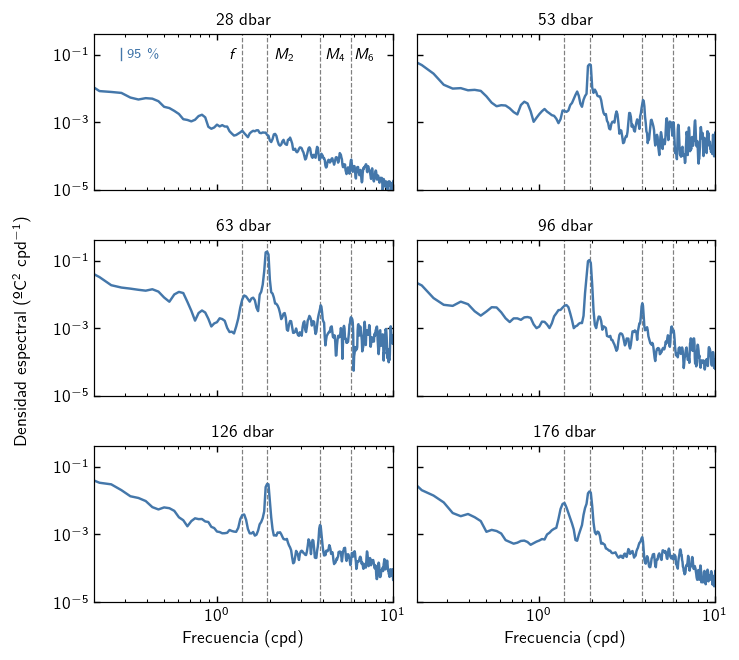

In [30]:
vlines = [coriolis_freq_cpd, M2_cpd, M4_cpd, M6_cpd]
texts = ['f', 'M2', 'M4', ]

figsize=(get_figsize(0.95, 0.9))
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=figsize)

#limits
ylim = (10**-5, 4*10**-1)

axs[0,0].set_xlim(2*10**-1, 10**1)
axs[0,0].set_ylim(ylim)
for ax in axs.reshape(6):
    ax.vlines(vlines, *ylim, ls='--', color='grey', lw=0.7)
axs[0,0].text(vlines[0] - 0.2, 10**-1, '$f$', ha='left', fontsize=9, va='center')
axs[0,0].text(vlines[1] + 0.2, 10**-1, '$M_2$', ha='left', fontsize=9, va='center')
axs[0,0].text(vlines[2] + 0.3, 10**-1, '$M_4$', ha='left', fontsize=9, va='center')
axs[0,0].text(vlines[3] + 0.3, 10**-1, '$M_6$', ha='left', fontsize=9, va='center')


axs[0,0].loglog(freqs_28, psd_28)
axs[0,0].set_title('28 dbar')

axs[0,1].loglog(freqs_53, psd_53)
axs[0,1].set_title('53 dbar')


axs[1,0].loglog(freqs_63, psd_63)
axs[1,0].set_title('63 dbar')


axs[1,1].loglog(freqs_96, psd_96)
axs[1,1].set_title('96 dbar')


axs[2,0].loglog(freqs_126, psd_126)
axs[2,0].set_title('126 dbar')
axs[2,0].set_xlabel('Frecuencia (cpd)')


axs[2,1].loglog(freqs_176, psd_176)
axs[2,1].set_title('176 dbar')
axs[2,1].set_xlabel('Frecuencia (cpd)')


chi_2 = dof_28 / chi2.ppf([0.025, 0.975], dof_28)
y_bar = 10**-1
conf = y_bar * chi_2
axs[0,0].plot([0.09, 0.09], conf, transform=axs[0,0].get_yaxis_transform(), c=colors[0], lw=0.8)
axs[0,0].text(0.11, y_bar, '95 $\%$', transform=axs[0,0].get_yaxis_transform(), fontsize=8, va='center',
             color=colors[0])

fig.supylabel('Densidad espectral (ºC$^2$ cpd$^{-1}$)', fontsize=10)

fig.tight_layout()
fig.subplots_adjust(wspace=0.08)
#fig.savefig(figures_dir / 'welch_column.pdf', dpi=300)

plt.gcf().set_dpi(125)
plt.show()

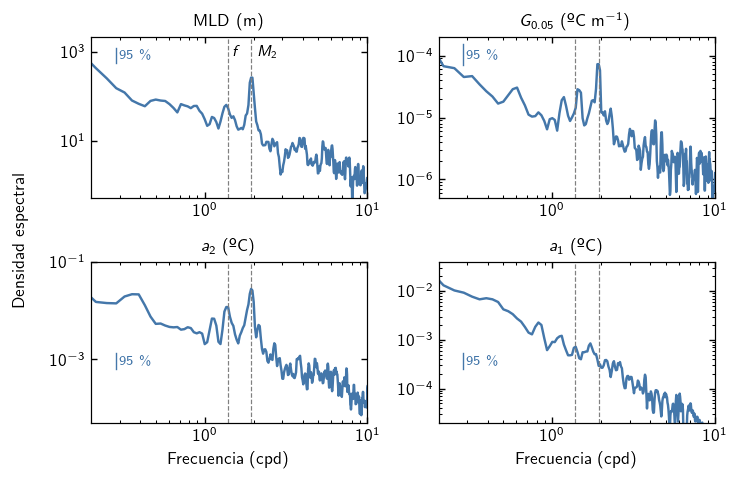

In [66]:
figsize = (get_figsize(0.95, 0.66))
fig = plt.figure(figsize=figsize)
gs = plt.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.loglog(freqs_D1, psd_D1)
ax1.set_ylim(5*10**-1,2.2*10**3)
ax1.set_title('MLD (m)')


ax2 = fig.add_subplot(gs[0, 1])
ax2.loglog(freqs_G05, psd_G05)
ax2.set_ylim(5*10**-7, 2*10**-4)
ax2.set_title('$G_{0.05}$ (ºC m$^{-1}$)')

ax3 = fig.add_subplot(gs[1, 0])
ax3.loglog(freqs_a2, psd_a2)
ax3.set_ylim(5*10**-5, 10**-1)
ax3.set_title('$a_2$ (ºC)')
ax3.set_xlabel('Frecuencia (cpd)')

ax4 = fig.add_subplot(gs[1, 1])
ax4.loglog(freqs_a1, psd_a1)
ax4.set_ylim(2*10**-5, 4*10**-2)
ax4.set_xlabel('Frecuencia (cpd)')
ax4.set_title('$a_1$ (ºC)')

freq = 1/9*24
vlines = [coriolis_freq_cpd, M2_cpd]

for ax in fig.get_axes():
    ax.set_xlim(2*10**-1, 10**1)
    ax.vlines(vlines, *ax.get_ylim(), ls='--', color='grey', lw=0.7)
    

ax1.text(vlines[0] + 0.1, 10**3, '$f$', ha='left', fontsize=9, va='center')
ax1.text(vlines[1] + 0.2, 10**3, '$M_2$', ha='left', fontsize=9, va='center')
#ax1.text(vlines[3] + 0.3, 10**3, '$M_4$', ha='left', fontsize=9, va='center')
#ax1.text(vlines[4] + 0.3, 10**3, '$M_6$', ha='left', fontsize=9, va='center')


chi_2 = dof_28 / chi2.ppf([0.025, 0.975], dof_28)
y_bar_ax1 = 8.2*10**2
ax1.plot([0.09, 0.09], chi_2*y_bar_ax1, transform=ax1.get_yaxis_transform(), c=colors[0], lw=0.8)
ax1.text(0.10, y_bar_ax1, '95 $\%$', transform=ax1.get_yaxis_transform(), fontsize=8, va='center', color=colors[0])


y_bar_ax2 = 1*10**-4
ax2.plot([0.09, 0.09], chi_2*y_bar_ax2, transform=ax2.get_yaxis_transform(), c=colors[0], lw=0.8)
ax2.text(0.10, y_bar_ax2, '95 $\%$', transform=ax2.get_yaxis_transform(), fontsize=8, va='center', color=colors[0])

y_bar_ax3 = 9*10**-4
ax3.plot([0.09, 0.09], chi_2*y_bar_ax3, transform=ax3.get_yaxis_transform(), c=colors[0], lw=0.8)
ax3.text(0.10, y_bar_ax3, '95 $\%$', transform=ax3.get_yaxis_transform(), fontsize=8, va='center', color=colors[0])

y_bar_ax4 = 3.6*10**-4
ax4.plot([0.09, 0.09], chi_2*y_bar_ax4, transform=ax4.get_yaxis_transform(), c=colors[0], lw=0.8)
ax4.text(0.10, y_bar_ax4, '95 $\%$', transform=ax4.get_yaxis_transform(), fontsize=8, va='center', color=colors[0])


fig.supylabel('Densidad espectral', fontsize=10)
fig.tight_layout()
#fig.subplots_adjust(, left=0.092)
fig.savefig(figures_dir / 'welch_parametres.pdf', dpi=300)

plt.gcf().set_dpi(125)
plt.show()

In [94]:
date_1 = datetime(2018, 11, 24)
period_1 = [datetime(2018, 11, 16, 11), date_1]

date_2 = datetime(2019, 1, 5)
date_3 = datetime(2019, 1, 14)
period_3 = [date_2, date_3]

date_4 = datetime(2018, 11, 30)
date_5 = datetime(2018, 12, 9)
period_2 = [date_4, date_5]

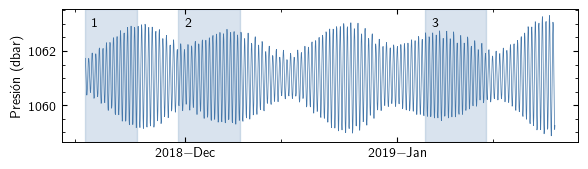

In [124]:
fig, ax = plt.subplots(figsize=get_figsize(0.95, 0.3))
slice_ = slice(None, datetime(2019, 1, 24,), 4)

ax.plot(bot_pres[slice_].index, bot_pres.pres[slice_], lw=0.5)
ax.set_ylabel('Presión (dbar)')
ax.axvspan(*period_1, color=colors[0], alpha=0.2)
ax.text(period_1[0] + timedelta(days=1), 1062.9, '1')
ax.axvspan(*period_2, color=colors[0], alpha=0.2)
ax.text(period_2[0]  + timedelta(days=1), 1062.9, '2')

ax.axvspan(*period_3, color=colors[0], alpha=0.2)
ax.text(period_3[0] +  timedelta(days=1), 1062.9, '3')


ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b"))
ax.xaxis.set_minor_locator(mdates.DayLocator(15))


fig.tight_layout()
fig.savefig(figures_dir / 'bottom_pres_with_periods.pdf', dpi=300)
plt.show()

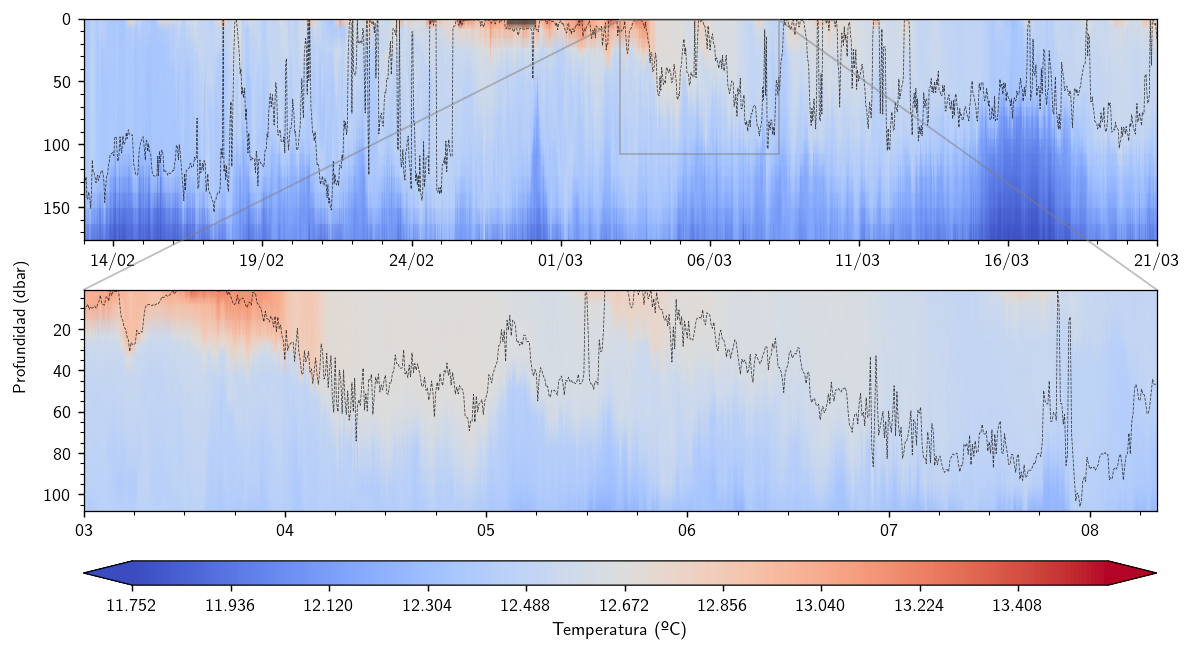

21.60833333333333


In [154]:
slice_ = slice(datetime(2019, 2, 13), datetime(2019, 3, 21), 120*2)
chain_period = chain.sel(date=slice_, depth=slice(1, 176))
gs = plt.GridSpec(3, 1, height_ratios=[1, 1, 0.11])
fig = plt.figure(figsize=get_figsize(0.97, 0.55, rotate=True))
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
cax = fig.add_subplot(gs[2])
cmap = plt.colormaps['coolwarm']

locator = mdates.AutoDateLocator(minticks=4, maxticks=None)
formatter = mdates.ConciseDateFormatter(locator)
minor_locator = mdates.AutoDateLocator(minticks=6)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(minor_locator)


ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

levels = MaxNLocator(nbins=256).tick_values(chain_period.temp.min(), chain_period.temp.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
ax.set_ylim(176, 0)
x, y = np.meshgrid(chain_period.date, chain_period.depth)


im = ax.pcolormesh(x.T, y.T, chain_period.temp, cmap=cmap, norm=norm, shading='gouraud', rasterized=True)

xx = np.linspace(0, len(chain_period.date.data) - 1, 1200, dtype='int')

ax.plot(chain.date.loc[slice_].data[xx], fit_chain[slice_].D1[xx], c='black', lw=0.45, ls='--', alpha=0.7)

ax.tick_params(axis='x', which='both', direction='out', top=None)
ax.tick_params(axis='y', which='both', direction='out', right=None)

### ax2
xlim = [datetime(2019, 3, 3), datetime(2019, 3, 8, 8)]
ax2.set_xlim(*xlim)
ax2.set_ylim(1, 108)
slice_2 = slice(*xlim, 120)
chain_period_2 = chain.sel(date=slice_2, depth=slice(1, 108))
x, y = np.meshgrid(chain_period_2.date, chain_period_2.depth)
im = ax2.pcolormesh(x.T, y.T, chain_period_2.temp, cmap=cmap, norm=norm, shading='gouraud')
xx = np.linspace(0, len(chain_period_2.date.data) - 1, 1200, dtype='int')
ax2.plot(chain_period_2.date.data[xx], fit_chain[slice_2].D1[xx], c='black', lw=0.45, ls='--', alpha=0.7)


ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d"))
ax2.xaxis.set_minor_locator(mdates.HourLocator([6, 12, 18]))


ax2.tick_params(axis='x', which='both', direction='out', top=None)
ax2.tick_params(axis='y', which='both', direction='out', right=None)
#ax2.xaxis.set_minor_locator(minor_locator)

cbar = fig.colorbar(im, cax=cax, extend='both', orientation="horizontal")
cbar.ax.set_xlabel('Temperatura (ºC)')
cbar.ax.tick_params(which='minor', axis='x', bottom=False)
cbar.ax.tick_params(which='major', axis='x', direction='out')


ax.indicate_inset_zoom(ax2)
ax2.set_ylim(108, 1)

fig.supylabel('Profundidad (dbar)', fontsize=9)
fig.tight_layout()
fig.savefig(figures_dir / 'column_march.png', dpi=300)
plt.gcf().set_dpi(130)     
plt.show()
print(len(chain_period.date.data)/1200*120*5/60)

In [185]:
def wide_plot(figsize, data_chain, fit_chain, loc_dates):
    fig, ax = plt.subplots(figsize=figsize)
    zz = np.linspace(0, 200, 300)
    for i, loc in enumerate(loc_dates):
        pres_loc = data_chain.meassured_depth.loc[loc].data
        temp_loc = data_chain.temp.loc[loc].data
        date_loc_str = np.datetime_as_string(data_chain.date.loc[loc].data, unit='D')
        date_loc = data_chain.date.loc[loc].data
        D1 = fit_chain.loc[date_loc].D1
        day = int(date_loc_str.split('-')[-1])
        pres_loc = pres_loc[np.isfinite(temp_loc)]
        temp_loc = temp_loc[np.isfinite(temp_loc)]
        date_loc = data_chain.date.loc[loc].data
        
        D1_central_pos = fit_function(D1, fit_chain, date_loc) + i*0.9
        ax.plot([D1_central_pos - 0.23, D1_central_pos + 0.23], [D1, D1], c='k', lw=0.7, alpha=0.9)
        ax.plot(fit_function(zz, fit_chain, date_loc) + i*0.9, zz, lw=0.8, marker=' ', alpha=0.9, c=colors[0])
        ax.scatter(temp_loc + i*0.9, pres_loc, s=3.2, c=colors[0])
        if (i + 1) % 2:
            ax.text(temp_loc[0] + i*0.9, -10, day, ha='center')
        ax.set_ylim(200, 0)
    fig.tight_layout()
    ax.set_xlim(min(data_chain.temp.loc[loc_dates[0]]) - 0.9, 
                max(data_chain.temp.loc[loc_dates[-1]]) + len(loc_dates)*0.9)
    ax.tick_params(which='minor', top=False, bottom=False)
    fig.savefig(figures_dir / 'spring_profiles.pdf')    
    plt.show()

def daily_profiles_ax(ax, data_chain, fit_chain, loc_dates, offs=0.9):
    zz = np.linspace(0, 200, 300)
    for i, loc in enumerate(loc_dates):
        pres_loc = data_chain.meassured_depth.loc[loc].data
        temp_loc = data_chain.temp.loc[loc].data
        date_loc_str = np.datetime_as_string(data_chain.date.loc[loc].data, unit='D')
        date_loc = data_chain.date.loc[loc].data
        D1 = fit_chain.loc[date_loc].D1
        day = int(date_loc_str.split('-')[-1])
        pres_loc = pres_loc[np.isfinite(temp_loc)]
        temp_loc = temp_loc[np.isfinite(temp_loc)]
        date_loc = data_chain.date.loc[loc].data
        
        D1_central_pos = fit_function(D1, fit_chain, date_loc) + i*offs
        ax.plot([D1_central_pos - 0.23, D1_central_pos + 0.23], [D1, D1], c='k', lw=0.7, alpha=0.9)
        ax.plot(fit_function(zz, fit_chain, date_loc) + i*offs, zz, lw=0.8, marker=' ', alpha=0.9, c=colors[0])
        ax.scatter(temp_loc + i*offs, pres_loc, s=3.2, c=colors[0])
        if (i + 1) % 2:
            ax.text(temp_loc[0] + i*offs, -10, day, ha='center')
        ax.set_ylim(200, 0)
    ax.set_xlim(min(data_chain.temp.loc[loc_dates[0]]) - offs, 
                max(data_chain.temp.loc[loc_dates[-1]]) + len(loc_dates)*offs)
    ax.tick_params(which='minor', top=False, bottom=False)
    


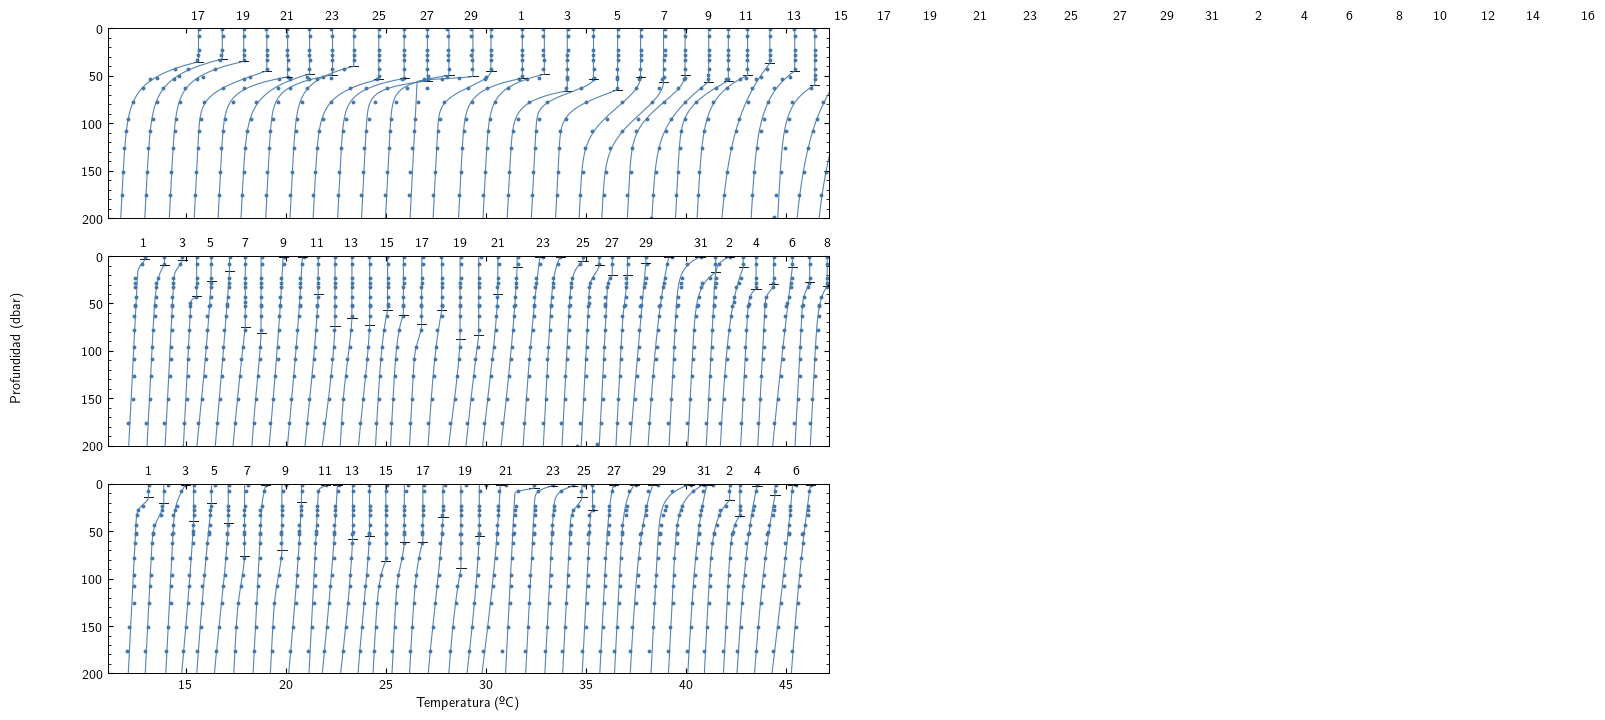

In [183]:
dates_march = chain.date.sel(date=slice(datetime(2019, 3, 1, 2), datetime(2019, 4, 8, 2), 120*6*24))
dates_february = chain.date.sel(date=slice(datetime(2019, 2, 1), datetime(2019, 2, 28), 120*6*24))
dates_1 = chain.date.sel(date=slice(datetime(2018, 11, 17), datetime(2019, 1, 17), 120*6*24))
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=get_figsize(0.97, 0.9, rotate=True), sharex=True)
daily_profiles_ax(ax1, chain, fit_chain, dates_1, offs=1.2)
daily_profiles_ax(ax2, chain, fit_chain, dates_march)
daily_profiles_ax(ax3, chain, fit_chain, dates_march[:-1] + np.timedelta64(12, 'h'))
fig.supylabel('Profundidad (dbar)', fontsize=10)
ax3.set_xlabel('Temperatura (ºC)')

#fig.tight_layout()
fig.savefig(figures_dir / 'spring_profiles.pdf')
plt.show()

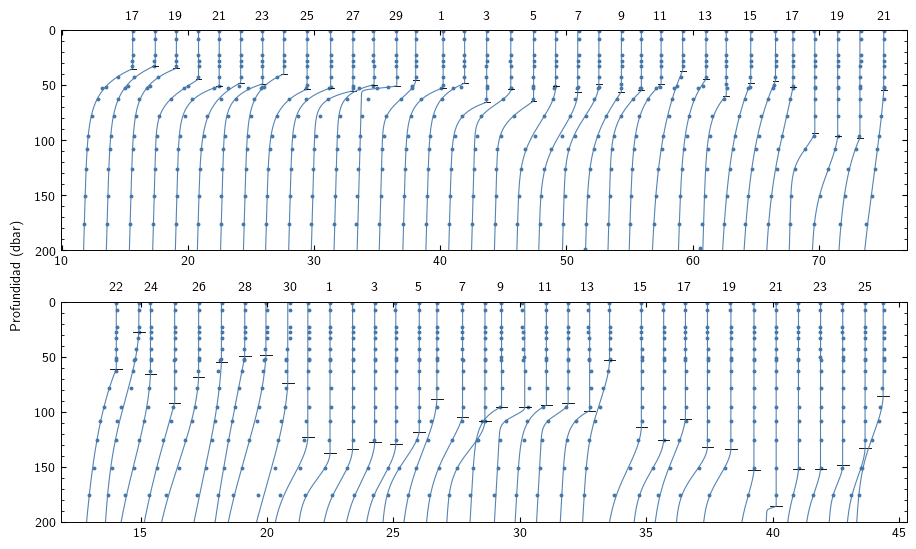

In [205]:
dates_march = chain.date.sel(date=slice(datetime(2019, 3, 1, 2), datetime(2019, 4, 8, 2), 120*6*24))
dates_february = chain.date.sel(date=slice(datetime(2019, 2, 1), datetime(2019, 2, 28), 120*6*24))
dates_1 = chain.date.sel(date=slice(datetime(2018, 11, 17), datetime(2018, 12, 21), 120*6*24))
dates_2 = chain.date.sel(date=slice(datetime(2018, 12, 22), datetime(2019, 1, 26), 120*6*24))

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=get_figsize(0.97, 0.6, rotate=True))
daily_profiles_ax(ax1, chain, fit_chain, dates_1, offs=1.8)
daily_profiles_ax(ax2, chain, fit_chain, dates_2)
#daily_profiles_ax(ax3, chain, fit_chain, dates_march[:-1] + np.timedelta64(12, 'h'))
fig.supylabel('Profundidad (dbar)', fontsize=10)
ax3.set_xlabel('Temperatura (ºC)')

fig.tight_layout()
fig.savefig(figures_dir / 'spring_profiles.pdf')
plt.show()

In [197]:
np.datetime_as_string(chain.date[-1] - chain.date[0])

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

## Oscilaciones columna M2

### Noviembre

In [15]:
dn = 1 # get datapoints every 60 seconds, not every 5
date_1 = datetime(2018, 11, 24)

nov_fit = TidalComponentsFit.compute(fit_chain, period=[None, date_1, dn])

#nov_term = column_coefs([28, 33, 43, 48, 53, 63, 78, 96])
nov_term = column_coefs([28, 33, 43, 48, 53, 63, 78, 96, 108, 126, 151, 176])

nov_term.compute(chain, period=[None, date_1])

nov_G05 = coef_dataframe(G05.x, period=[None, date_1, dn])
nov_delta05ci = coef_dataframe(delta05.x, period=[None, date_1, dn])

#nov_term.clean() # todos los termistores tienen M2
nov_fit.clean()

In [12]:
def plot_column_oscilation(figsize, column_coefs, component, mld_coef, delta05_coef, 
                           pos1, pos2, x_arrow, arrow_width=0.000005, head_width=0.01, ylim=None, save=None):
    x = []
    ci = []
    depths = column_coefs.depths
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    
    mld_mean = mld_coef.attrs['mean']
    mld_ampl = mld_coef.loc[component]['A']
    delta_mean = delta05_coef.attrs['mean']

    delta_ampl = delta05_coef.loc[component]['A']
    
    for depth in depths:
        coef = getattr(column_coefs, 'd' + str(depth))
        value = coef.loc[component]['A']
        confidence = coef.loc[component]['A_ci']
        ci.append(confidence)
        x.append(value)
        
    fig, ax = plt.subplots(figsize=figsize)
    ax.errorbar(x, depths, xerr=ci, marker='o', linestyle='none', lw=0.8, capsize=3, c='k')
    ax.axhline(mld_mean, ls='--')
    ax.axhline(mld_mean + delta_mean, ls='--', c=colors[1])
    xlim = ax.get_xlim()
    
    if ylim is None:
        ax.set_ylim(max(depths) + 2, min(depths) - 2)
        
    else:
        ax.set_ylim(*ylim)
    mld_mean_arr = np.full(2, mld_mean)
    
    ax.fill_between((xlim[0], xlim[1]), (mld_mean_arr-mld_ampl), (mld_mean_arr+mld_ampl), color=colors[0], 
                     alpha=0.35)
    ax.fill_between((xlim[0], xlim[1]), (mld_mean + delta_mean-delta_ampl), (mld_mean + delta_mean+delta_ampl), 
                     color=colors[1], alpha=0.35)

    ax.set_xlim(*xlim)
    ax.set_xlabel('Amplitud de oscilación (ºC)')
    ax.set_ylabel('Profundidad (dbar)')
    #ax.set_title('Componente ' + component)
    
    norm_x = xlim[1] - xlim[0]
    norm_y = ax.get_ylim()[0] - ax.get_ylim()[1]

    
    ax.arrow(x = x_arrow, y = mld_mean - mld_ampl, dy=2*mld_ampl, dx=0, width=arrow_width*norm_x, 
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.02*norm_y, color='k')
    ax.arrow(x = x_arrow, y = mld_mean + mld_ampl, dy=-2*mld_ampl, dx=0, width=arrow_width*norm_x, 
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.02*norm_y, color='k')

    ax.arrow(x = x_arrow, y = mld_mean + delta_mean - delta_ampl, dy=2*delta_ampl, dx=0, width=arrow_width*norm_x,
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.02*norm_y, color='k')
    ax.arrow(x = x_arrow, y = mld_mean + delta_mean + delta_ampl, dy=-2*delta_ampl, dx=0, width=arrow_width*norm_x,
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.02*norm_y, color='k')
    ax.text(pos1[0], pos1[1], 'MLD', fontsize=9, va='center', ha='center')
    ax.text(pos2[0], pos2[1], r'$\Delta_{0.05}$', fontsize=9, va='center', ha='center')
    
    fig.tight_layout()
    
    if save is not None:
        fig.savefig(figures_dir / save, dpi=300)
    
    plt.show()

### Enero

In [14]:
dn = 1 # get datapoints every 60 seconds, not every 5
date_2 = datetime(2019, 1, 5)
date_3 = datetime(2019, 1, 14) # o 14

jan_fit = TidalComponentsFit.compute(fit_chain, period=[date_2, date_3, dn])

#jan_term = column_coefs([78, 96, 108, 126, 151, 176])
jan_term = column_coefs([28, 33, 43, 48, 53, 63, 78, 96, 108, 126, 151, 176])

jan_term.compute(chain, period=[date_2, date_3, dn])

jan_G05 = coef_dataframe(G05.x, period=[date_2, date_3, dn])
jan_delta05ci = coef_dataframe(delta05.x, period=[date_2, date_3, dn])

#jan_term.clean()
jan_fit.clean()

### Principios noviembre

In [13]:
dn = 1 
date_4 = datetime(2018, 11, 30)
date_5 = datetime(2018, 12, 9)

dec_fit = TidalComponentsFit.compute(fit_chain, period=[date_4, date_5, dn])

#dec_term = column_coefs([28, 33, 43, 48, 53, 63, 78, 96, 108, 126])
depths_coefs = [28, 33, 43, 48, 53, 63, 78, 96, 108, 126, 151, 176]
dec_term = column_coefs(depths_coefs)

dec_term.compute(chain, period=[date_4, date_5, dn])

dec_G05 = coef_dataframe(G05.x, period=[date_4, date_5, dn])
dec_delta05ci = coef_dataframe(delta05.x, period=[date_4, date_5, dn])

#jan_term.clean()
dec_fit.clean()

In [11]:
def plot_column_oscilation_axes(ax, column_coefs, component, mld_coef, delta05_coef, 
                           pos1, pos2, x_arrow, arrow_width=0.000005, head_width=0.03, ylim=None, save=None):
    x = []
    ci = []
    depths = column_coefs.depths
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    
    mld_mean = mld_coef.attrs['mean']
    mld_ampl = mld_coef.loc[component]['A']
    delta_mean = delta05_coef.attrs['mean']

    delta_ampl = delta05_coef.loc[component]['A']
    
    for depth in depths:
        coef = getattr(column_coefs, 'd' + str(depth))
        value = coef.loc[component]['A']
        confidence = coef.loc[component]['A_ci']
        ci.append(confidence)
        x.append(value)
        
    ax.errorbar(x, depths, xerr=ci, marker='o', linestyle='none', lw=0.6, capsize=2.5, c='k', markersize=3.5)
    ax.axhline(mld_mean, ls='--')
    ax.axhline(mld_mean + delta_mean, ls='--', c=colors[1])
    xlim = ax.get_xlim()
    
    #if ylim is None:
    #    ax.set_ylim(max(depths) + 2, min(depths) - 2)
        
    #else:
    #    ax.set_ylim(*ylim)
    mld_mean_arr = np.full(2, mld_mean)
    
    ax.fill_between((xlim[0], xlim[1]), (mld_mean_arr-mld_ampl), (mld_mean_arr+mld_ampl), color=colors[0], 
                     alpha=0.35)
    
    ax.fill_between((xlim[0], xlim[1]), (mld_mean + delta_mean-delta_ampl), (mld_mean + delta_mean+delta_ampl), 
                     color=colors[1], alpha=0.35)

    ax.set_xlim(*xlim)
    #ax.set_xlabel('Amplitud de oscilación (ºC)')
    #ax.set_ylabel('Profundidad (dbar)')
    #ax.set_title('Componente ' + component)
    
    norm_x = xlim[1] - xlim[0]
    norm_y = ax.get_ylim()[0] - ax.get_ylim()[1]

    
    ax.arrow(x = x_arrow, y = mld_mean - mld_ampl, dy=2*mld_ampl, dx=0, width=arrow_width*norm_x, 
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.012*norm_y, color='k')
    ax.arrow(x = x_arrow, y = mld_mean + mld_ampl, dy=-2*mld_ampl, dx=0, width=arrow_width*norm_x, 
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.012*norm_y, color='k')

    ax.arrow(x = x_arrow, y = mld_mean + delta_mean - delta_ampl, dy=2*delta_ampl, dx=0, width=arrow_width*norm_x,
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.012*norm_y, color='k')
    ax.arrow(x = x_arrow, y = mld_mean + delta_mean + delta_ampl, dy=-2*delta_ampl, dx=0, width=arrow_width*norm_x,
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.012*norm_y, color='k')
    ax.text(pos1[0], pos1[1], 'MLD', fontsize=9, va='center', ha='center')
    ax.text(pos2[0], pos2[1], r'$\Delta_{0.05}$', fontsize=9, va='center', ha='center')

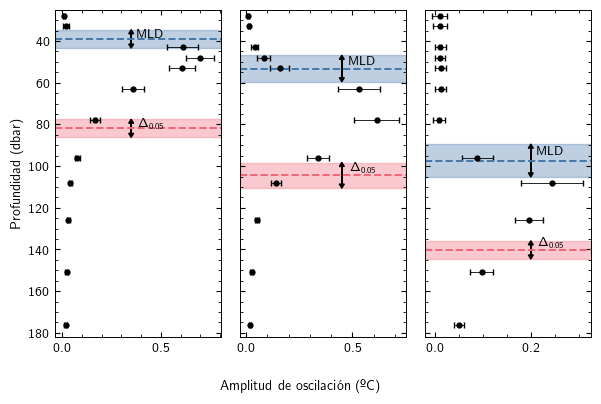

In [16]:
fig, axs = plt.subplots(1, 3, figsize=get_figsize(0.97, 0.66), sharey=True)
axs[0].set_ylim(182, 25)


plot_column_oscilation_axes(axs[0], nov_term, 'M2', nov_fit.D1, nov_delta05ci, pos1=[0.45, 36.8], 
                       pos2=[0.45, 79.785], x_arrow=0.35, save='colum_oscilation_M2_november.pdf')


plot_column_oscilation_axes(axs[1], dec_term, 'M2', dec_fit.D1, dec_delta05ci, pos1=[0.55, 50], 
                       pos2=[0.55, 101], x_arrow=0.45,
                       save='colum_oscilation_M2_dec.pdf')

plot_column_oscilation_axes(axs[2], jan_term, 'M2', jan_fit.D1, nov_delta05ci, pos1=[0.242, 93], 
                       pos2=[0.242, 137], x_arrow=0.20, ylim=[181, 73],
                       save='colum_oscilation_M2_jan.pdf')

axs[0].set_ylabel('Profundidad (dbar)')
fig.supxlabel('Amplitud de oscilación (ºC)', fontsize=10)
fig.tight_layout()
fig.savefig(figures_dir / 'three.pdf')
plt.show()

In [45]:
def plot_multiple_profiles_ax(ax, df, data, date_i, ylim=None, legend=True):
        
    markers = ['o', 's', '^', 'v', '<', '>', 'd']
    ls = ['-', '--', ':', '-.']

    for (i, date_) in enumerate(date_i): 
        if isinstance(date_i, (int, np.integer)):
            data_i = data.isel(date=date_, method='nearest')
            mld = df.iloc[date_]['D1']

        else:
            data_i = data.sel(date=date_, method='nearest')
                #mld = df.loc[i, 'D1']
                
        pres_i = data_i.meassured_depth.data
        temp_i = data_i.temp.data
        date_i_str = np.datetime_as_string(data_i.date, unit='s')
        pres_i = pres_i[np.isfinite(temp_i)]
        temp_i = temp_i[np.isfinite(temp_i)]
        
        # switch statement for seting label
        match i:
            case 0:
                label_i = 't=0'
                
            case 1|2:
                label_i = 't=' + str(i) + 'M$_2$/3'
                
            case 3:
                label_i = 't=$M_2$'
                
        zz = np.linspace(1, pres_i[-1] + 5, 300)
        ax.scatter(temp_i, pres_i, marker=markers[i], label=label_i)
        ax.plot(fit_function(zz, df, date_), zz, lw=1.2, marker=' ', alpha=0.9, ls=ls[i])
        
        if ylim is None:
            ax.set_ylim(135, 0)
        else:
            ax.set_ylim(*ylim)
        if legend:
            ax.legend()

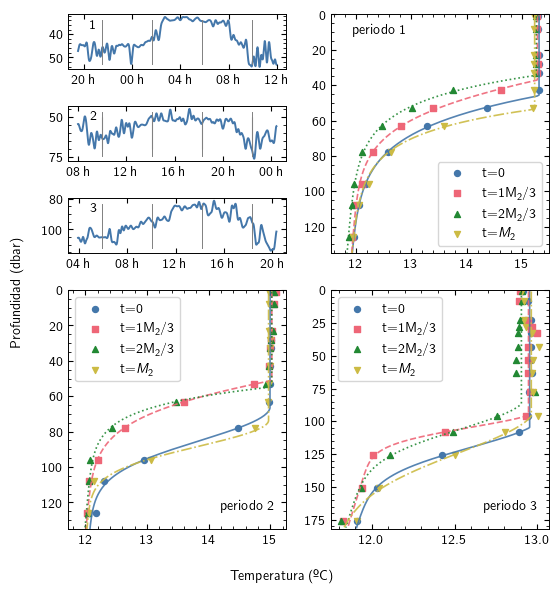

In [68]:
figsize = get_figsize(0.9, 1.05)
ref_date_2 = datetime(2018, 12 ,4, 9, 59, 40)
ref_date_1 = datetime(2018, 11, 20, 21, 32, 10)
ref_date_3 = datetime(2019, 1, 12, 5, 55, 40)
slice_1 = slice(ref_date_1 - timedelta(hours=2), ref_date_1 + timedelta(hours=14.42))
slice_2 = slice(ref_date_2 - timedelta(hours=2), ref_date_2 + timedelta(hours=14.42))
slice_3 = slice(ref_date_3 - timedelta(hours=2), ref_date_3 + timedelta(hours=14.42))


gs = plt.GridSpec(4, 2, height_ratios=(1, 1, 1, 4.35))
fig = plt.figure(figsize=figsize)
ax000 = fig.add_subplot(gs[0, 0])
ax000.plot(chain.date.loc[slice_1], D1_filt1024[slice_1])
ax000.xaxis.set_major_locator(mdates.HourLocator(np.arange(0, 24, 4)))
ax000.xaxis.set_major_formatter(mdates.DateFormatter("%H h"))
ax000.tick_params(which='minor', top=False, bottom=False)
ax000.invert_yaxis()



ax001 = fig.add_subplot(gs[1, 0])
ax001.plot(chain.date.loc[slice_2], D1_filt1024[slice_2])
ax001.xaxis.set_major_locator(mdates.HourLocator(np.arange(0, 24, 4)))
ax001.xaxis.set_major_formatter(mdates.DateFormatter("%H h"))
ax001.tick_params(which='minor', top=False, bottom=False)

ax001.invert_yaxis()


ax002 = fig.add_subplot(gs[2, 0])
ax002.plot(chain.date.loc[slice_3], D1_filt1024[slice_3])
ax002.xaxis.set_major_locator(mdates.HourLocator(np.arange(0, 24, 4)))
ax002.xaxis.set_major_formatter(mdates.DateFormatter("%H h"))
ax002.tick_params(which='minor', top=False, bottom=False)

ax002.invert_yaxis()

ax10 = fig.add_subplot(gs[3, 0])
i_dates = [ref_date_2 + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
for date in i_dates:
    ax001.axvline(date, 0.1, 0.9, lw=0.7, c='grey')
ax001.vlines(i_dates, 50, 70, lw=0.8, color='grey')
plot_multiple_profiles_ax(ax10, fit_chain, chain, i_dates)


ax01 = fig.add_subplot(gs[:3, 1])
i_dates = [ref_date_1 + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
for date in i_dates:
    ax000.axvline(date, 0.1, 0.9, lw=0.7, c='grey')
plot_multiple_profiles_ax(ax01, fit_chain, chain, i_dates)


ax02 = fig.add_subplot(gs[3, 1])
i_dates = [ref_date_3 + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
for date in i_dates:
    ax002.axvline(date, 0.1, 0.9, lw=0.7, c='grey')
plot_multiple_profiles_ax(ax02, fit_chain, chain, i_dates, ylim=(182, 0))

ax000.text(0.1, 0.75, '1', transform=ax000.transAxes)
ax001.text(0.1, 0.75, '2', transform=ax001.transAxes)
ax002.text(0.1, 0.75, '3', transform=ax002.transAxes)

ax01.text(0.1, 0.92, 'periodo 1', transform=ax01.transAxes)
ax10.text(0.70, 0.08, 'periodo 2', transform=ax10.transAxes)
ax02.text(0.70, 0.08, 'periodo 3', transform=ax02.transAxes)


fig.supxlabel('Temperatura (ºC)', fontsize=10)
fig.supylabel('Profundidad (dbar)', fontsize=10)
fig.tight_layout()
fig.savefig(figures_dir / 'complex_figure_tides.pdf')
plt.show()

### Periodos 

In [35]:
period_1 = slice(None, datetime(2018, 11, 24), 360)
period_2 = slice(datetime(2018, 11, 30), datetime(2018, 12, 9), 360)
period_3 = slice(datetime(2019, 1, 5), datetime(2019, 1, 14), 360)

chain_period_1 = chain.sel(date=period_1)
chain_period_2 = chain.sel(date=period_2)
chain_period_3 = chain.sel(date=period_3)

fit_period_1 = fit_chain[period_1]
fit_period_2 = fit_chain[period_2]
fit_period_3 = fit_chain[period_3]



period_list = [chain_period_1, chain_period_2, chain_period_3]
fit_list = [fit_period_1, fit_period_2, fit_period_3]

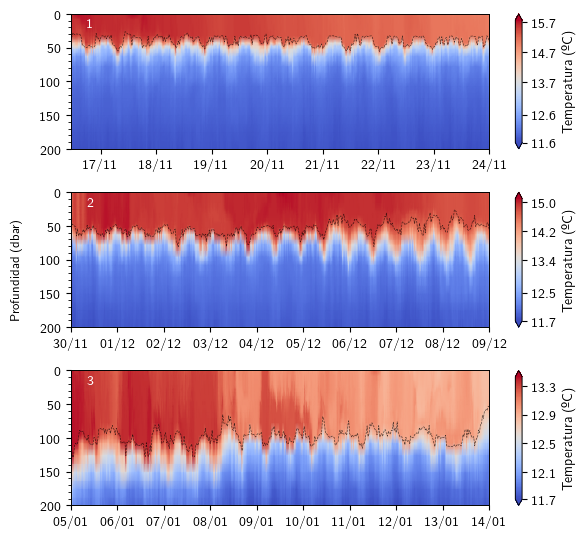

In [43]:
fig, axs = plt.subplots(3, figsize=get_figsize(0.97, 0.9), sharex=False)
cmap = plt.colormaps['coolwarm']
cbars = []
for (ax, period, fit) in zip(axs.reshape(3), period_list, fit_list):
    
    #locator = mdates.AutoDateLocator(minticks=4, maxticks=None)
    #formatter = mdates.ConciseDateFormatter(locator)
    #minor_locator = mdates.AutoDateLocator(minticks=6)
    
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    #ax.xaxis.set_minor_locator(minor_locator)
    
    levels = MaxNLocator(nbins=256).tick_values(period.temp.min(), period.temp.max())
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    ax.set_ylim(200, 0)
    x, y = np.meshgrid(period.date, chain.depth)
    
    im = ax.pcolormesh(x.T, y.T, period.temp, cmap=cmap, norm=norm, shading='gouraud')
    cbar = fig.colorbar(im, ax=ax, extend='both')
    cbars.append(cbar)
    
    ax.plot(period.date, fit.D1, c='black', lw=0.45, ls='--', alpha=0.7)
    
    cbar.ax.tick_params(which='minor', axis='y', right=False)
    cbar.ax.tick_params(which='major', axis='y', direction='out')
    cbar.ax.set_ylabel('Temperatura (ºC)')
    ax.tick_params(axis='x', which='both', direction='out', top=None)
    ax.tick_params(axis='x', which='minor', bottom=None)
    ax.tick_params(axis='y', which='both', direction='out', right=None)

cbars[0].ax.set_yticks(np.round(np.linspace(11.64, 15.67, 5),1), minor=False)
cbars[1].ax.set_yticks(np.round(np.linspace(11.70, 15.0, 5),1), minor=False)
cbars[2].ax.set_yticks(np.round(np.linspace(11.71, 13.3, 5),1), minor=False)


axs[0].text(0.04, 0.9, '1', transform=axs[0].transAxes, c='white')

axs[1].text(0.04, 0.9, '2', transform=axs[1].transAxes, c='white')
axs[2].text(0.04, 0.9, '3', transform=axs[2].transAxes, c='white')

fig.supylabel('Profundidad (dbar)', fontsize=9)
fig.tight_layout()
fig.savefig(figures_dir / 'periods_utide.pdf', dpi=300)
plt.show()

### Internal waves D1 and G005

In [10]:
def plot_D1_and_G005(figsize, D1, G005, period=[None, None], xlim=None, ylim=None, save=None):
    slice_ = slice(*period)
    D1_ = D1.loc[slice_]
    G005_ = G005.loc[slice_]
    date = D1[slice_].index

    fig, ax1 = plt.subplots(figsize=figsize)
    locator = mdates.AutoDateLocator(minticks=4, maxticks=None)
    formatter = mdates.ConciseDateFormatter(locator)
    minor_locator = mdates.AutoDateLocator(minticks=6)
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_minor_locator(minor_locator)
    ax1.plot(date, D1_)
    ax1.set_ylabel(r'$MLD$ (dbar)', color=colors[0])  # we already handled the x-label with ax1
    #ylim = ax1.get_ylim()
    #ax1.set_ylim(ylim[1], ylim[0])
    ax1.tick_params(axis='y', colors=colors[0], which='both')


    ax2 = ax1.twinx()
    ax2.plot(date, G005_, color=colors[1])
    ax2.tick_params(axis='y', colors=colors[1], which='both')
    ax2.set_ylabel('$G_{0.05}$', color=colors[1])  # we already handled the x-label with ax1
    fig.tight_layout()
    if save is not None:
        fig.savefig(figures_dir / save, dpi=300)
    plt.gcf().set_dpi(130)
    plt.show()

In [144]:
def plot_D1_and_G005_ax(ax, D1, G005, period=[None, None], xlim=None, ylim=None, mld_label=True, 
                        G005_label=True, lw=None, locator='day'):
    slice_ = slice(*period)
    D1_ = D1.loc[slice_]
    G005_ = G005.loc[slice_]
    date = D1[slice_].index

    if mld_label:
        ax.set_ylabel(r'MLD (dbar)', color=colors[0])  # we already handled the x-label with ax1
    #ylim = ax1.get_ylim()
    #ax1.set_ylim(ylim[1], ylim[0])
    ax.tick_params(axis='y', colors=colors[0], which='both')


    ax2 = ax.twinx()
    if lw is None:
        ax.plot(date, D1_)
        ax2.plot(date, G005_, color=colors[1])
    else:
        ax.plot(date, D1_, lw=lw)
        ax2.plot(date, G005_, color=colors[1], lw=lw)
    ax2.tick_params(axis='y', colors=colors[1], which='both')
    if locator == 'day':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        
    elif locator == 'hour':
        
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_minor_locator(mdates.MinuteLocator([30]))

    if G005_label:
        ax2.set_ylabel('$G_{0.05}$ (ºC/m)', color=colors[1])  # we already handled the x-label with ax1

In [116]:
colors[1]

'#EE6677'

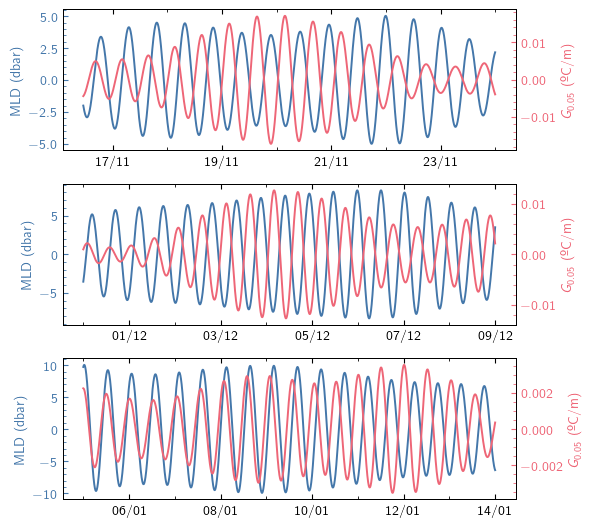

In [119]:
figsize=get_figsize(0.95, 0.9)
fig, axs = plt.subplots(3, figsize=figsize)
plot_D1_and_G005_ax(axs[0], D1_bandpass_M2, G005_bandpass_M2, period=period_1)
plot_D1_and_G005_ax(axs[1], D1_bandpass_M2, G005_bandpass_M2, period=period_2)
plot_D1_and_G005_ax(axs[2], D1_bandpass_M2, G005_bandpass_M2, period=period_3)
fig.tight_layout()
fig.savefig(figures_dir / 'D1_G005_three.pdf')
plt.show()


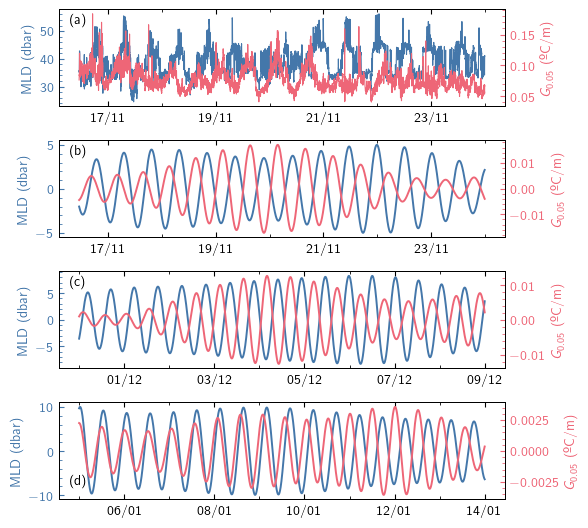

In [160]:
figsize=get_figsize(0.95, 0.9)
fig, axs = plt.subplots(4, figsize=figsize)
plot_D1_and_G005_ax(axs[0], D1_filt64, G005_filt64, period=period_1, lw=0.8)
plot_D1_and_G005_ax(axs[1], D1_bandpass_M2, G005_bandpass_M2, period=period_1)
plot_D1_and_G005_ax(axs[2], D1_bandpass_M2, G005_bandpass_M2, period=period_2)
plot_D1_and_G005_ax(axs[3], D1_bandpass_M2, G005_bandpass_M2, period=period_3)
fig.tight_layout()

axs[0].text(0.026, 0.85, '(a)', transform=axs[0].transAxes)
axs[1].text(0.026, 0.85, '(b)', transform=axs[1].transAxes)
axs[2].text(0.026, 0.85, '(c)', transform=axs[2].transAxes)
axs[3].text(0.026, 0.15, '(d)', transform=axs[3].transAxes)


fig.savefig(figures_dir / 'D1_G005_three.pdf')
plt.show()

### Internal solitons D1 vs G005

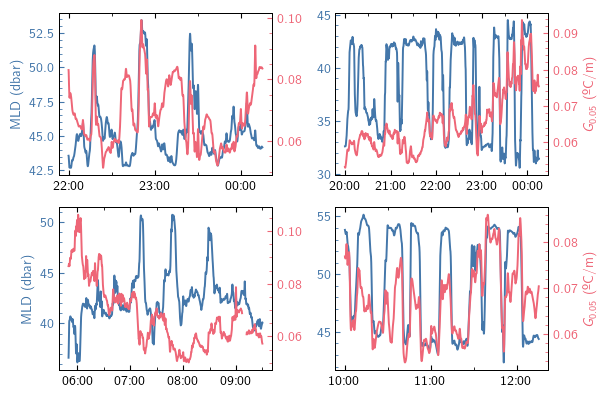

In [145]:
G005_filt64.loc[slice(datetime(2018, 11, 18, 9, 7), datetime(2018, 11, 18, 9, 12))] = np.nan
figsize=get_figsize(0.98, 0.66)
fig, axs = plt.subplots(2, 2, figsize=figsize)
plot_D1_and_G005_ax(axs[0, 0], D1_filt64, G005_filt64, period=period_s1f, G005_label=False, locator='hour')
plot_D1_and_G005_ax(axs[0, 1], D1_filt64, G005_filt64, period=period_s2f, mld_label=False, locator='hour')
plot_D1_and_G005_ax(axs[1, 0], D1_filt64, G005_filt64, period=period_s3f, G005_label=False, locator='hour')
plot_D1_and_G005_ax(axs[1, 1], D1_filt64, G005_filt64, period=period_s4f, mld_label=False, locator='hour')

fig.tight_layout()
fig.savefig(figures_dir / 'D1_G005_solitons.pdf')
plt.show()

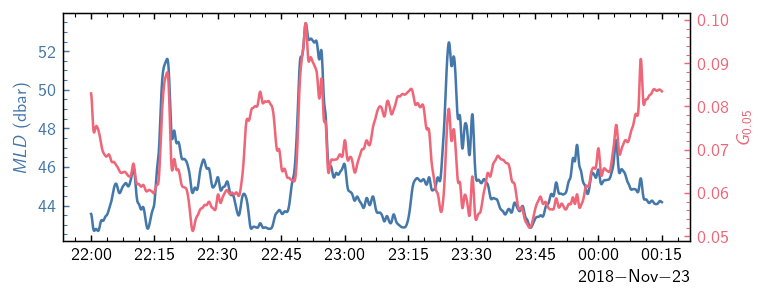

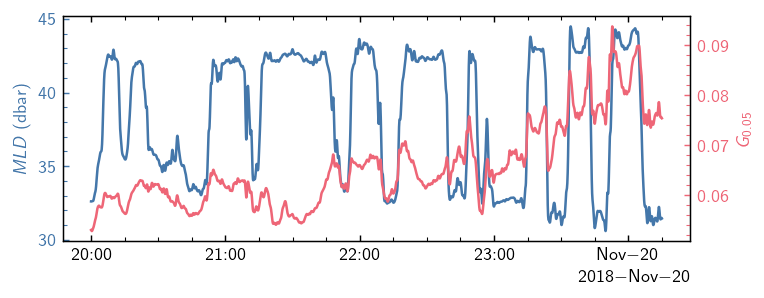

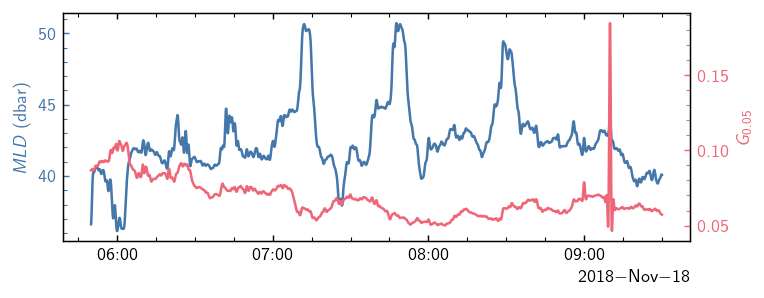

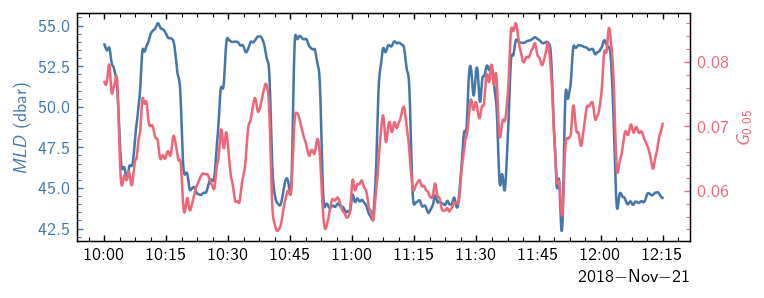

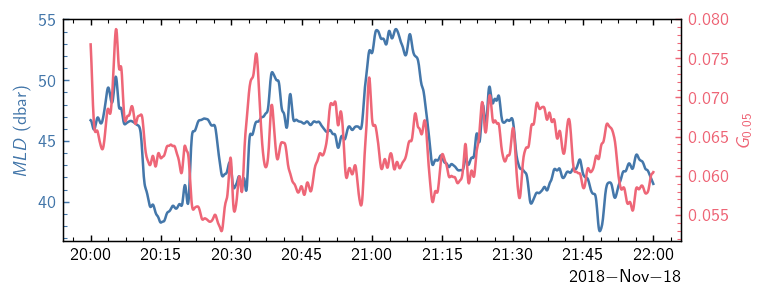

In [110]:
figsize=get_figsize(0.95, 0.4)
plot_D1_and_G005(figsize, D1_filt64, G005_filt64, period=period_s1f, save='soliton_1.pdf')
plot_D1_and_G005(figsize, D1_filt64, G005_filt64, period=period_s2f, save='soliton_2.pdf')
plot_D1_and_G005(figsize, D1_filt64, G005_filt64, period=period_s3f, save='soliton_3.pdf')
plot_D1_and_G005(figsize, D1_filt64, G005_filt64, period=period_s4f, save='soliton_4.pdf')
plot_D1_and_G005(figsize, D1_filt64, G005_filt64, period=period_s5f, save='soliton_5.pdf')


## SOLITONES

In [171]:
slice_ = slice(*period_s2f, 5)
slice_ = slice(datetime(2018, 11, 19, 18, 0), datetime(2018, 11, 20, 1, 25), 5)
chain_period = chain.sel(date=slice_).where(chain.depth!=48, drop=True).where(chain.depth < 100)


z_ = []
y_ = []
therm_ = []

for i in range(len(chain_period.date.data)):
    z_interp, y_interp = interpolate(chain_period.depth.data, chain_period.temp.data[i], np.linspace(20, 90, 40))
    z_.append(z_interp)
    y_.append(y_interp)
    idx = np.argmin(abs(y_interp - 14.6))
    therm_.append(z_interp[idx])

z = z_[0]
therm_ = np.asarray(therm_)

In [161]:
therm_

array([36.15384615, 36.15384615, 36.15384615, ..., 36.15384615,
       36.15384615, 36.15384615])

In [150]:
print(slice_)

slice(datetime.datetime(2018, 11, 19, 20, 0), datetime.datetime(2018, 11, 20, 0, 15), 5)


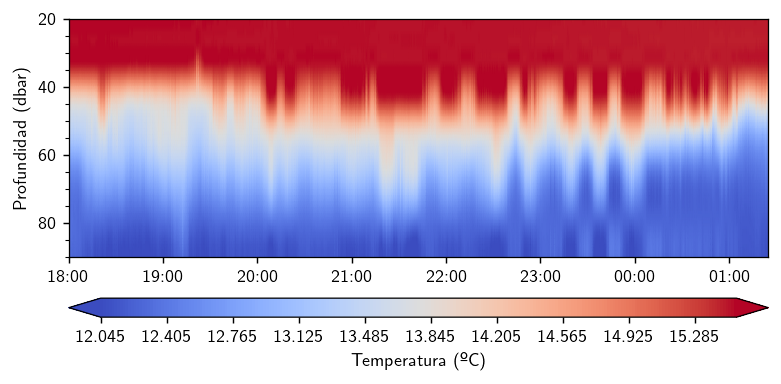

In [173]:
fig, ax = plt.subplots(figsize=get_figsize(0.97, 0.5))
cmap = plt.colormaps['coolwarm']

locator = mdates.HourLocator(interval=1)
#formatter = mdates.ConciseDateFormatter(locator)
#minor_locator = mdates.AutoDateLocator(minticks=6)
formatter = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
#ax.xaxis.set_minor_locator(minor_locator)

levels = MaxNLocator(nbins=256).tick_values(chain_period.temp.min(), chain_period.temp.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
ax.set_ylim(90, 20)

x, y = np.meshgrid(chain_period.date, z)


divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='8%', pad=0.32)
im = ax.pcolormesh(x.T, y.T, y_, cmap=cmap, norm=norm, shading='gouraud', rasterized=True)
cbar = fig.colorbar(im, cax=cax, extend='both', orientation="horizontal")

xx = np.linspace(0, len(chain_period.date.data) - 1, 900, dtype='int')

#ax.plot(chain_period.date.data[xx], therm_[xx], c='white', lw=0.45, alpha=0.7)

cbar.ax.tick_params(which='minor', axis='x', bottom=False)
cbar.ax.tick_params(which='major', axis='x', direction='out')
ax.tick_params(axis='x', which='both', direction='out', top=None)
ax.tick_params(axis='x', which='minor', bottom=None)
ax.tick_params(axis='y', which='both', direction='out', right=None)

cbar.ax.set_xlabel('Temperatura (ºC)')

ax.set_ylabel('Profundidad (dbar)')
fig.tight_layout()
fig.savefig(figures_dir / 'soliton_column.pdf', dpi=300)
plt.gcf().set_dpi(130)     
plt.show()

AttributeError: 'DataFrame' object has no attribute 'sel'

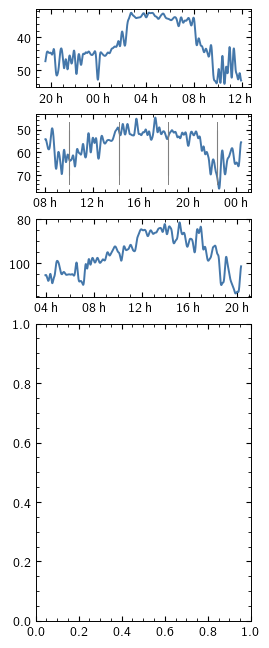

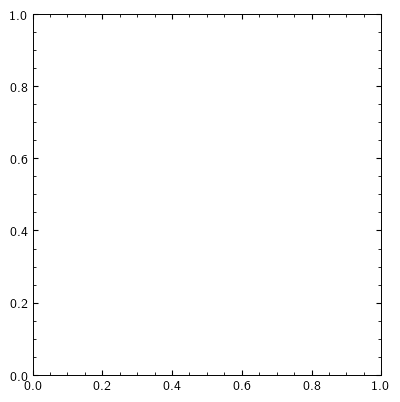

In [41]:
figsize = get_figsize(0.97, 1.3)
ref_date_2 = datetime(2018, 12 ,4, 9, 59, 40)
ref_date_1 = datetime(2018, 11, 20, 21, 32, 10)
ref_date_3 = datetime(2019, 1, 12, 5, 55, 40)
slice_1 = slice(ref_date_1 - timedelta(hours=2), ref_date_1 + timedelta(hours=14.42))
slice_2 = slice(ref_date_2 - timedelta(hours=2), ref_date_2 + timedelta(hours=14.42))
slice_3 = slice(ref_date_3 - timedelta(hours=2), ref_date_3 + timedelta(hours=14.42))


gs = plt.GridSpec(4, 2, height_ratios=(1, 1, 1, 3.8))
fig = plt.figure(figsize=figsize)
ax000 = fig.add_subplot(gs[0, 0])
ax000.plot(chain.date.loc[slice_1], D1_filt1024[slice_1])
ax000.xaxis.set_major_locator(mdates.HourLocator(np.arange(0, 24, 4)))
ax000.xaxis.set_major_formatter(mdates.DateFormatter("%H h"))
ax000.invert_yaxis()



ax001 = fig.add_subplot(gs[1, 0])
ax001.plot(chain.date.loc[slice_2], D1_filt1024[slice_2])
ax001.xaxis.set_major_locator(mdates.HourLocator(np.arange(0, 24, 4)))
ax001.xaxis.set_major_formatter(mdates.DateFormatter("%H h"))
ax001.invert_yaxis()


ax002 = fig.add_subplot(gs[2, 0])
ax002.plot(chain.date.loc[slice_3], D1_filt1024[slice_3])
ax002.xaxis.set_major_locator(mdates.HourLocator(np.arange(0, 24, 4)))
ax002.xaxis.set_major_formatter(mdates.DateFormatter("%H h"))
ax002.invert_yaxis()

ax10 = fig.add_subplot(gs[3, 0])
i_dates = [ref_date_2 + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
for date in i_dates:
    ax001.axvline(date, 0.1, 0.9, lw=0.7, c='grey')
ax001.vlines(i_dates, 50, 70, lw=0.8, color='grey')
plot_multiple_profiles_ax(ax10, fit_chain, chain, i_dates)


ax01 = fig.add_subplot(gs[:3, 1])
i_dates = [ref_date_1 + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
for date in i_dates:
    ax000.axvline(date, 0.1, 0.9, lw=0.7, c='grey')
plot_multiple_profiles_ax(ax01, fit_chain, chain, i_dates)


ax02 = fig.add_subplot(gs[3, 1])
i_dates = [ref_date_3 + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
for date in i_dates:
    ax002.axvline(date, 0.1, 0.9, lw=0.7, c='grey')
plot_multiple_profiles_ax(ax02, fit_chain, chain, i_dates, ylim=(182, 0))

fig.supxlabel('Temperatura (ºC)', fontsize=10)
fig.supylabel('Profundidad (dbar)', fontsize=10)
fig.tight_layout()
fig.savefig(figures_dir / 'complex_figure_tides.pdf')
plt.show()

In [1]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=get_figsize(0.97, 0.6))
ref_date_0 = datetime(2018, 11, 21, 11, 1)
#ref_date_0 = datetime(2018, 11, 21, 11, 5, 5)

i_dates_0 = [ref_date_0 + timedelta(minutes=5*i) for i in range(4)]
plot_multiple_profiles_ax(ax0, fit_chain, chain, i_dates_0, ylim=(115, 20), legend=False)

#ref_date_1 = datetime(2018, 11, 22, 22, 11)
ref_date_1 = datetime(2018, 11, 20, 21, 59, 30)
i_dates_1 = [ref_date_1 + timedelta(minutes=5*i) for i in range(4)]
plot_multiple_profiles_ax(ax1, fit_chain, chain, i_dates_1, ylim=(115, 20), legend=False)

ax0.text(0.1, 0.9, ref_date_0, transform=ax0.transAxes)
ax1.text(0.1, 0.9, ref_date_1, transform=ax1.transAxes)

fig.supxlabel('Temperatura (ºC)', fontsize=10)
ax0.set_ylabel('Profundidad (dbar)')
fig.tight_layout()
fig.savefig(figures_dir / 'solitons_fit.pdf', dpi=300)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
def wavelet_plot()

In [99]:
i_dates_1

[datetime.datetime(2018, 11, 20, 21, 59, 30),
 datetime.datetime(2018, 11, 20, 22, 4, 30),
 datetime.datetime(2018, 11, 20, 22, 9, 30),
 datetime.datetime(2018, 11, 20, 22, 14, 30)]

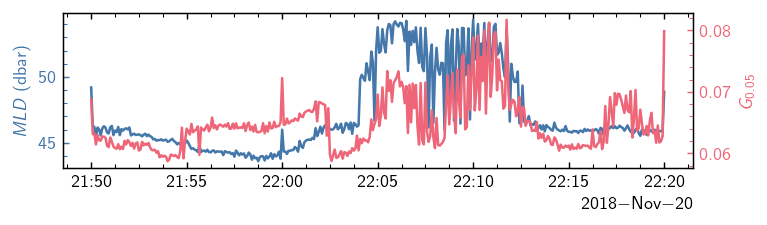

In [90]:
plot_D1_and_G005(get_figsize(0.97, 0.3), D1_, G005_, 
                 period=[ref_date_1 - timedelta(minutes=10), ref_date_1 +  timedelta(minutes=20)])

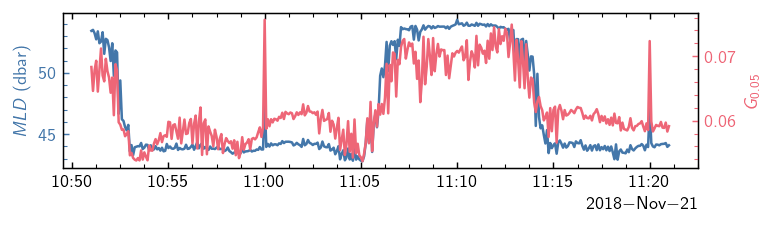

In [88]:
plot_D1_and_G005(get_figsize(0.97, 0.3), D1_, G005_, 
                 period=[ref_date_0 - timedelta(minutes=10), ref_date_0 +  timedelta(minutes=20)])

In [28]:
from wavelet_classes import Wavelet

In [35]:
a = Wavelet(chain.temp[:, 8], chain.date, [None, datetime(2018, 11, 24), 2])

In [36]:
a.compute()

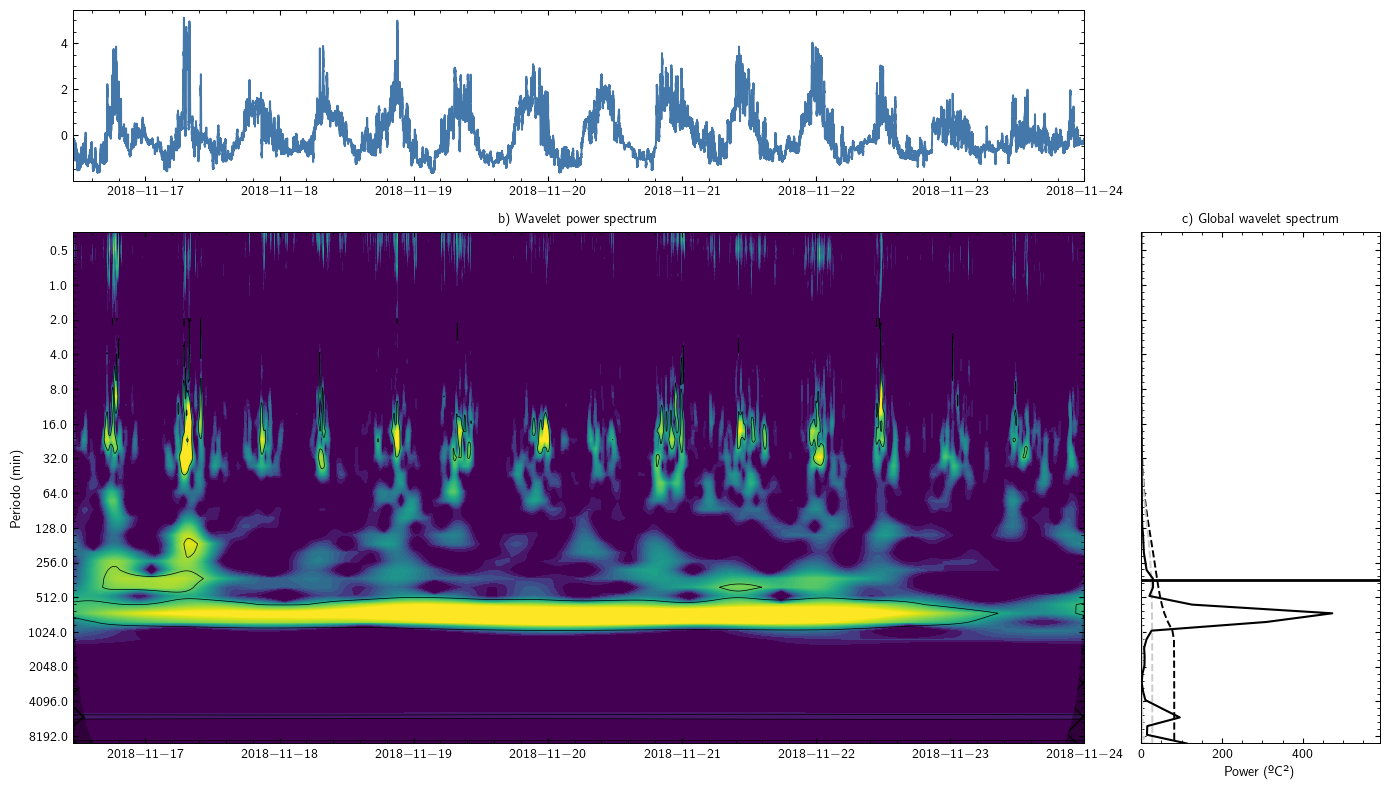

In [40]:
a.complete_plot(hlines=[np.log2(360)])

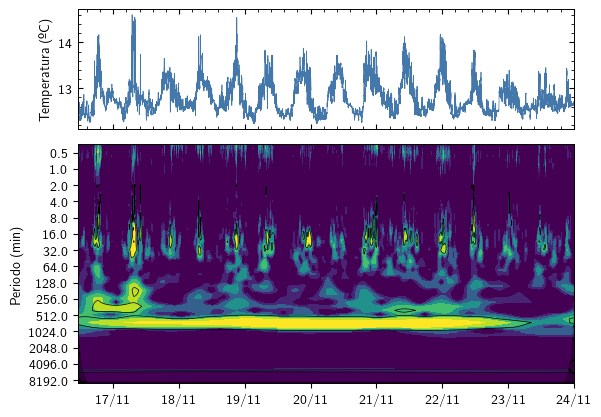

In [19]:
gs = plt.GridSpec(2, 1, height_ratios=[1, 2])
fig = plt.figure(figsize=get_figsize(0.97, 0.7))
ax1 = fig.add_subplot(gs[0])
ax1.plot(a.date, a.orig_signal, lw=0.5)
ax1.set_ylabel('Temperatura (ºC)')

ax2 = fig.add_subplot(gs[1], sharex=ax1)
a.plot_spectrum_ax(ax2)

ax1.tick_params(labelbottom=False)
ax2.tick_params(which='both', direction='out', right=None, top=None)
ax2.tick_params(which='minor', left=None, bottom=None)
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))

fig.tight_layout()
fig.savefig(figures_dir / 'wavelet_temp_nov.png', dpi=300)
plt.show()

In [15]:
b = Wavelet(chain.temp[:, 8], chain.date, [None,datetime(2018, 12, 15), 2])
b.compute()

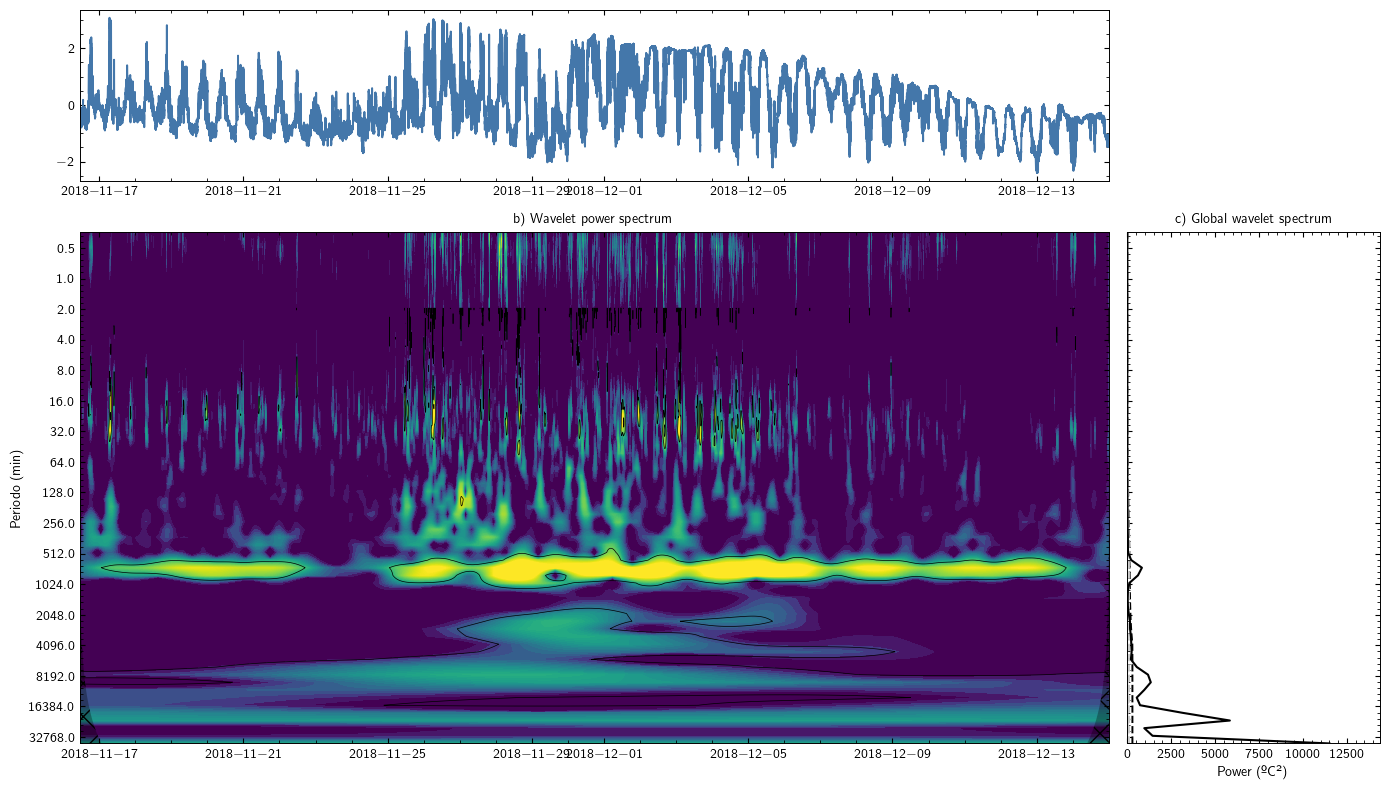

In [12]:
b.complete_plot(ski)

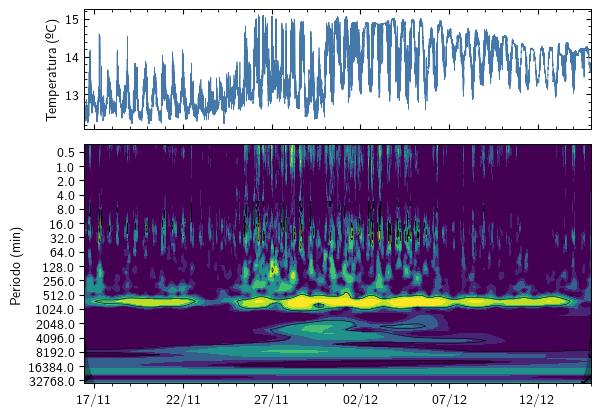

In [14]:
gs = plt.GridSpec(2, 1, height_ratios=[1, 2])
fig = plt.figure(figsize=get_figsize(0.97, 0.7))
ax1 = fig.add_subplot(gs[0])
ax1.plot(b.date, b.orig_signal, lw=0.5)
ax1.set_ylabel('Temperatura (ºC)')

ax2 = fig.add_subplot(gs[1], sharex=ax1)
b.plot_spectrum_ax(ax2, skip=16, lw=0.4)

ax1.tick_params(labelbottom=False)
ax2.tick_params(which='both', direction='out', right=None, top=None)
ax2.tick_params(which='minor', left=None)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax2.xaxis.set_minor_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))


fig.tight_layout()
fig.savefig(figures_dir / 'wavelet_example.png', dpi=300)
plt.show()